<table>
 <tr align=left><td><img align=left src="./images/CC-BY.png">
 <td>Text provided under a Creative Commons Attribution license, CC-BY. All code is made available under the FSF-approved MIT license. (c) Kyle T. Mandli</td>
</table>

Note:  The presentation below largely follows part II in "Finite Difference Methods for Ordinary and Partial Differential Equations" by LeVeque (SIAM, 2007).

In [1]:
from __future__ import print_function

%matplotlib inline
import numpy
import matplotlib.pyplot as plt

# Numerical Solution to ODE Initial Value Problems - Part 2

# Overview -- so far

So far we have discussed 3 basic techniques for integration of ODE IVP's

* **Single-Step Multi-Stage** schemes (explicit and implicit)
* **Taylor's Series** Methods
* **Linear Multi-Step** Schemes (explicit and implicit)

as well as 
* **truncation error** of each method (and its relation to step-error)
* **adaptive stepping** 

# Overview -- to do

This notebook will continue the analysis of these methods to discuss the other important issues of
* **Convergence** (Global Error) -- does the discrete solution converge to the continuous analytic solution?
* **Stability** -- Are there limits to how large a time-step we can take?
* **Stiff Equations**:  consequences of stability
* **Implicit Methods**: Solution of non-linear systems of equation using **Newton's Method**

# Convergence

We can think of an ODE method as providing a sequence of approximations $U_N$ where here $N$ is the number of time steps needed to reach the final time of interest $t_f$, in effect we are increasing the resolution of the method.  We then say that a method is convergent if this sequence converges to the true solution at the same time
$$
    \lim_{N\rightarrow \infty} U_N = u(t_f).
$$

We can also define this in a more familiar way in terms of $\Delta t$ such that
$$
    N \Delta t = t_f ~~~~ \Rightarrow ~~~~ N = \frac{t_f}{\Delta t}
$$
so that our definition of convergence becomes
$$
    \lim_{\Delta t \rightarrow 0} U_{\Delta t} = u(t_f).
$$

In general for a method to be convergent it must be
 - **consistent** which as before meant that the local truncation error $T = \mathcal{O}(\Delta t^p)$ where $p > 0$,
 - **zero-stable** which implies that the sum total of the errors as $\Delta t \rightarrow 0$ is bounded and has the same order as $T$ (the truncation error) which we know goes to zero as $\Delta t \rightarrow 0$.
 
 
put another way,  a method is convergent if the **global error**

$$
    E = | U_N(t_f) - u(t_f)| \rightarrow 0\quad\mathrm{as}\quad N\rightarrow\infty
$$

### Example:  Forward Euler on a Linear Problem

Consider the simple linear problem

$$
    \frac{\text{d}u}{\text{d}t} = \lambda u \quad \text{with} \quad u(0) = u_0
$$

which we know has the solution $u(t) = u_0 e^{\lambda t}$.  Applying Euler's method to this problem leads to 

$$\begin{aligned}
    U_{n+1} &= U_n + \Delta t\lambda U_n \\
            &= (1 + \Delta t \lambda) U_n
\end{aligned}$$

We also know the local truncation error is defined by
$$\begin{aligned}
    T_n &= \frac{1}{\Delta t} \left[ U_{n+1} - u_{n+1} \right ] \\
        &= \frac{1}{\Delta t} \left[ (1 + \lambda \Delta t) u_n - u_{n+1} \right ]
\end{aligned}$$
which can be rearranged to find

$$
    u_{n+1} = (1 + \Delta t \lambda) u_n - \Delta t T_n.
$$

Note that all values here are in terms of the exact solution where as the application of Euler's method is in terms of the approximate solution.

Defining the global error as
$$
    E_{n} = u_n - U_n
$$

we can subtract the last two expressions to find

$$\begin{aligned}
    u_{n+1} - U_{n+1} &= \underbrace{(1 + \Delta t \lambda) u_n - \Delta t T_n}_{u_{n+1}} - \underbrace{(1 + \Delta t \lambda) U_n}_{U_{n+1}} \\
    E_{n+1} &= (1 + \Delta t \lambda) (u_n - U_n) - \Delta t T_n \\
            &= (1 + \Delta t \lambda) E_n - \Delta t T_n,
\end{aligned}$$

a recursive definition for the global error that connects it to the local truncation error.

Working backwards from the global error $E_n$ at maximum time step $n = t_f/\Delta t$,  the first few iterates of this look like

$$\begin{align}
    E_n &= (1 + \lambda \Delta t) E_{n - 1} - \Delta t T_{n-1} \\
    &= (1 + \lambda \Delta t) \left [(1 + \lambda \Delta t) E_{n - 2} - \Delta t T_{n-2} \right ] - \Delta t T_{n-1} \\
    &= (1 + \lambda \Delta t) \left [(1 + \lambda \Delta t) \left \{(1 + \lambda \Delta t) E_{n - 3} - \Delta t T_{n-3} \right \} - \Delta t T_{n-2} \right ] - \Delta t T_{n-1}
\end{align}$$

Which at this point looks like
$$
    E_n = (1 + \lambda \Delta t)^3E_{n-3} - \Delta t\sum_{i=1}^3 (1+\Delta t\lambda)^{i-1}T_{n-i}
$$

So taking it back $n$ steps ($3\rightarrow n$) gives
$$
    E_n = (1 + \lambda \Delta t)^nE_0 - \Delta t\sum_{i=1}^n (1+\Delta t\lambda)^{i-1}T_{n-i}
$$

Expanding this expression out backwards in time to $n=0$ leads to 
$$
    E_n = (1 + \Delta t \lambda)^n E_0 - \Delta t \sum^n_{i=1} (1 + \Delta t \lambda)^{i-1} T_{n - i}.
$$

Noting that $(1 + \Delta t \lambda)$ are the first two terms in the Taylor series for $e^{\lambda\Delta t}$ we will bound this term by

$$
    e^{\Delta t \lambda} \geq |1 + \Delta t \lambda|
$$

which then implies the term in the summation can be bounded by

$$
    |1 + \Delta t \lambda|^{n - 1} \leq e^{(n-1) \Delta t |\lambda|} \leq e^{n \Delta t |\lambda|} \leq e^{|\lambda| t_f}
$$

Using this expression in the expression for the global error we find
$$\begin{aligned}
    E_n &= (1 + \Delta t \lambda)^n E_0 - \Delta t \sum^n_{i=1} (1 + \Delta t \lambda)^{i-1} T_{n-i} \\
    |E_n| &\leq e^{|\lambda| \Delta t n} |E_0| + \Delta t \sum^n_{i=1} e^{|\lambda| t_f} |T_{n-i}| \\
          &\leq e^{|\lambda| t_f} \left(|E_0| + \Delta t \sum^n_{i=1} |T_{n - i}|\right) \\
          &\leq e^{|\lambda| t_f} \left(|E_0| + n \Delta t \max_{1 \leq i \leq n} |T_{n - i}|\right)
\end{aligned}$$
or

$$
\begin{aligned}
E_n &\leq e^{|\lambda| t_f} \left(|E_0| + t_f \max_{1 \leq i \leq n} |T_{n - i}|\right)
\end{aligned}
$$

In other words the global error is bounded by the original global error and the maximum one-step truncation error made multiplied by the number of time steps taken.  If $N = \frac{t_f}{\Delta t}$ as before and taking into account the local truncation error we can simplify this expression further to

$$
    |E_n| \leq e^{|\lambda| t_f} \left[|E_0| + t_f \left(\frac{1}{2} \Delta t |u''| + \mathcal{O}(\Delta t^2)\right ) \right]
$$

If we assume that we have used the correct initial condition $u_0$ then $E_0 \rightarrow 0$ as $\Delta t \rightarrow 0$ and we see that the global error $E_n$ is bounded by $\mathcal{O}(\Delta t)$, the same as the local truncation error:
$$
    |E_n| \leq e^{|\lambda| t_f} t_f \left(\frac{1}{2} \Delta t |u''| + \mathcal{O}(\Delta t^2)\right ) = \mathcal{O}(\Delta t).
$$

More generally,  it can be shown that for all single-step multi-stage schemes (of which Euler is the simplest), the Global error has the same order as the Truncation error, all of which scale as 

$$
    \Delta t^p,\quad p>0
$$

and therefore all of these schemes converge.

## Absolute Stability
Although zero-stability guarantees stability it is much more difficult to work with in general as the limit $\Delta t \rightarrow 0$ can be difficult to compute (and in general isn't ideal as it requires an infinite amount of computation).  Instead we often consider a finite $\Delta t$ and examine if the method is stable for this particular choice of $\Delta t$.  This has the practical upside that it will also tell us what particular $\Delta t$ will ensure that our method is indeed stable.

### Example
Consider the problem
$$
    u'(t) = \lambda (u - \cos t) - \sin t ~~~~ \text{with} ~~~~ u(0) = 1
$$

whose exact solution is 
$$
    u(t) = \cos t.
$$

We can compute an estimate for what $\Delta t$ we need to use by examining the truncation error for Euler's method

$$\begin{aligned}
    T &= \frac{1}{2} \Delta t u''(t) + \mathcal{O}(\Delta t^2) \\
      &= -\frac{1}{2} \Delta t \cos t + \mathcal{O}(\Delta t^2)
\end{aligned}$$

and therefore
$$
    |E_n| \leq \Delta t \max_{0 \leq t \leq t_f} |\cos t| = \Delta t.
$$

If we want a solution where $|E_n| < 10^{-3}$ then $\Delta t \approx 10^{-3}$.  Turning to the application of Euler's method lets apply this to the case where $\lambda = -10$ and $\lambda = -2100$.

In [2]:
# Implement vectorized Forward Euler  
def euler(f, t_span, u0, N):
    """ simple implementation of constant step-size forward euler method for vector valued f
        This doc string should have so much more in it
    """
    t = numpy.linspace(t_span[0], t_span[1],N)
    if numpy.isscalar(u0):
        u = numpy.empty(t.shape)
    else:
        u = numpy.empty((len(t),len(u0)))
    u[0] = u0
    delta_t = t[1] - t[0]
    for (n, t_n) in enumerate(t[:-1]):
        K1 = delta_t * f(t_n, u[n])
        u[n + 1] = u[n] + K1  
    return t, u.transpose()

In [3]:
# Compare accuracy between Euler for different values of lambda
f = lambda t, u, lam: lam * (u - numpy.cos(t)) - numpy.sin(t)
u_exact = lambda t: numpy.cos(t)
u_0 = u_exact(0.)

t_span = [0., 2.]
num_steps = [2**n for n in range(4, 9)]

Error: lambda =   10: [0.00585379 0.00265873 0.00126757 0.00061895 0.00030584]
Error: lambda = 2100: [3.68031712e+032 3.59591175e+061 5.64801260e+109 1.70130252e+186
 9.46746847e+297]


c:\Users\31040\anaconda3\Lib\site-packages\matplotlib\scale.py:255: RuntimeWarning: overflow encountered in power
  return np.power(self.base, values)


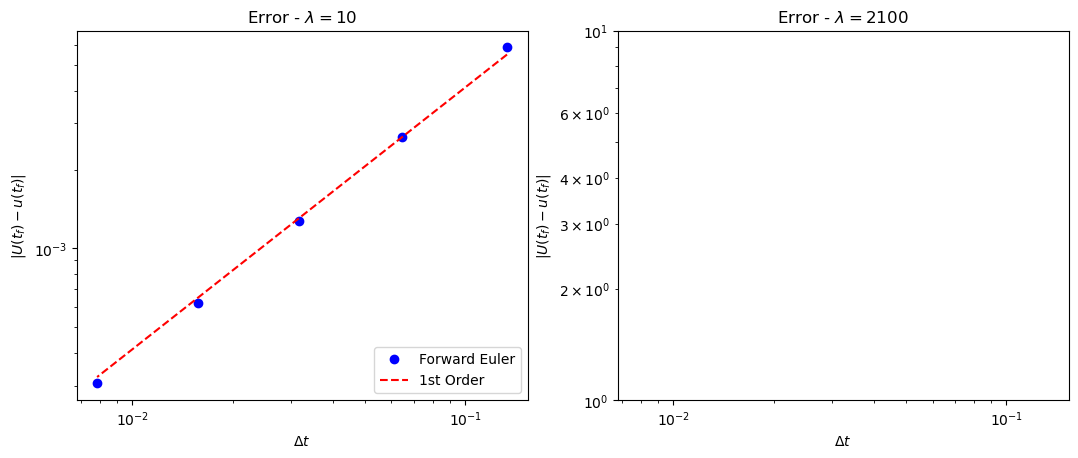

In [4]:
#num_steps = [2**n for n in range(15,20)]
delta_t = numpy.empty(len(num_steps))
error_10 = numpy.empty(len(num_steps))
error_2100 = numpy.empty(len(num_steps))

t_f = t_span[1]
u_f = u_exact(t_f)

for (i, N) in enumerate(num_steps):
    # Compute Euler solution
    ff = lambda t, u: f(t, u, -10.)
    t, U_10 = euler(ff, t_span, u_0, N) 
    delta_t[i] = t[1] - t[0]
    error_10[i] = numpy.abs(U_10[-1] - u_f) / numpy.abs(u_f)
    ff = lambda t, u: f(t, u, -2100.)    
    t, U_2100 = euler(ff, t_span, u_0, N) 
    error_2100[i] = numpy.abs(U_2100[-1] - u_f) / numpy.abs(u_f)

print('Error: lambda =   10: {}'.format(error_10))
print('Error: lambda = 2100: {}'.format(error_2100))    

# Plot error vs. delta_t
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
axes = fig.add_subplot(1, 2, 1)

axes.loglog(delta_t, error_10, 'bo', label='Forward Euler')

order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))
axes.loglog(delta_t, order_C(delta_t[1], error_10[1], 1.0) * delta_t**1.0, 'r--', label="1st Order")

axes.legend(loc=4)
axes.set_title("Error - $\lambda = 10$")
axes.set_xlabel("$\Delta t$")
axes.set_ylabel("$|U(t_f) - u(t_f)|$")

axes = fig.add_subplot(1, 2, 2)

axes.loglog(delta_t, error_2100, 'bo', label='Forward Euler')
axes.loglog(delta_t, order_C(delta_t[1], error_2100[1], 1.0) * delta_t**1.0, 'r--', label="1st Order")

axes.set_title("Error - $\lambda = 2100$")
axes.set_xlabel("$\Delta t$")
axes.set_ylabel("$|U(t_f) - u(t_f)|$")

plt.show()

So what went wrong with $\lambda = -2100$, the global error should go as

$$
    E_n = \mathcal{O}(\Delta t)?
$$

If $\Delta t \approx 10^{-3}$ then for the case $\lambda = -10$ the previous **global error** is multiplied by $1+\lambda\Delta t$

$$1 + 10^{-3} \cdot -10 = 0.99$$

which means the contribution from $E^n$ will slowly decrease as we take more time steps.  For the other case we have

$$1 + 10^{-3} \cdot -2100 = -1.1$$

which means that for this $\Delta t$ the error made in previous time steps will grow!  For this not to happen we would have to have $\Delta t < 1 / 2100$ which would lead to convergence again.

### A simple example
Consider our simplest test problem
$$
    u'(t) = \lambda u, \quad u(0) = u_0
$$

whose exact solution is 
$$
    u(t) = u_0 e^{\lambda t}.
$$
which for real $\lambda < 0$ should decay to zero as $t\rightarrow\infty$ 

### Question?

What is the **largest** step-size $\Delta t$ for an Euler method, such that the discrete solution $U_N\rightarrow 0$ as $N\rightarrow\infty$?

Euler's method on this simplest problem can be written

$$
\begin{align}
    U_{n+1} &= U_n + \Delta t f(U_n) = U_n + \Delta t \lambda U_n\\
            &= (1 + \lambda\Delta t)U_n\\
\end{align}
$$            

i.e. at each step the last solution is multiplied by the factor $(1 + \lambda\Delta t)$

After $N$ steps

$$
    U_N = (1 + \lambda\Delta t)^N U_0
$$ 

Assuming $\lambda < 0$ what is the largest step size $\Delta t$ such that $U_N\rightarrow 0$ as $N\rightarrow\infty$?


Hopefully it's clear that for this scheme to be stable requires

$$
    |1 + \lambda\Delta t| < 1
$$

The key parameter is actually the combination of $\lambda$ and the time step $z=\lambda\Delta t$, so stability requires that

$$
    | 1 + z | < 1
$$
or  𝑧∈[?,?]

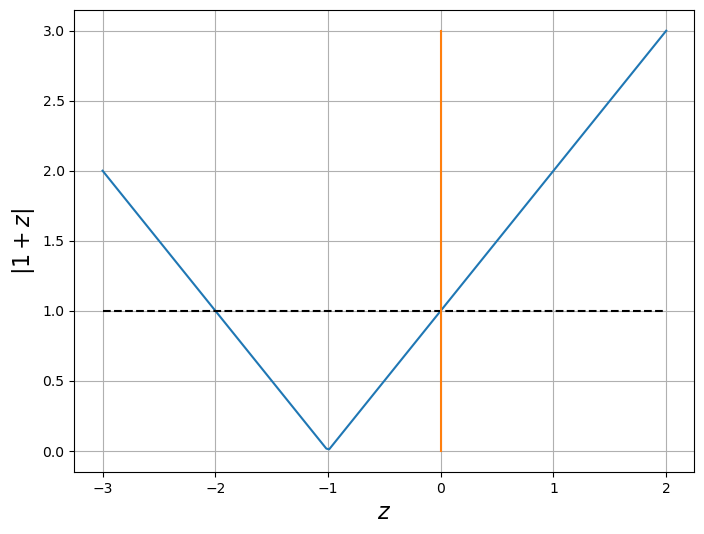

In [5]:
plt.figure(figsize=(8,6))
z = numpy.linspace(-3,2,200)
plt.plot(z,numpy.abs(1 + z))
plt.plot(z,numpy.ones(z.shape),'k--')
plt.plot([0.,0],[0.,3.])
plt.xlabel('$z$',fontsize=16)
plt.ylabel('$|1 + z|$',fontsize=16)
plt.grid()
plt.show()


Given $z\in[-2,0]$,  the  time step is simply

$$
    \Delta t = \frac{z}{\lambda}
$$
so the maximum time step we can take for $\lambda<0$ is

$$
    \Delta t = -\frac{2}{\lambda} > 0
$$


In [6]:
# Compare accuracy between Euler for different values of time steps and $\lambda = -1$
lam = -1.
f = lambda t, u :  lam * u
u_exact = lambda t: numpy.exp(lam * t)
u_0 = u_exact(0.)

t_span = [0., 10.]

N = 21
N = 11
N = 9
N = 6

N = 5
abs_z = numpy.abs(lam*t_span[-1]/(N-1))
print('Abs(z)={}'.format(abs_z))
t, u = euler(f, t_span, u_0, N)


Abs(z)=2.5


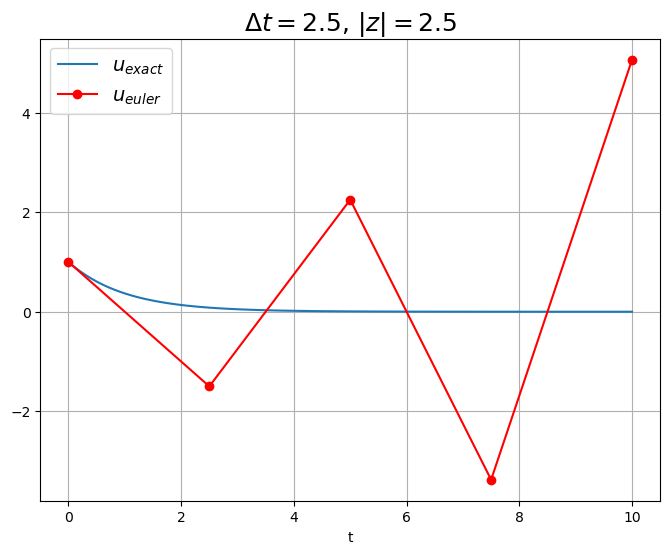

In [7]:
tt = numpy.linspace(0.,t_span[1],100)
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1,1,1)
axes.plot(tt, u_exact(tt),label='$u_{{exact}}$')
axes.plot(t, u, 'ro-', label='$u_{{euler}}$')
axes.set_xlabel('t')
axes.set_title('$\Delta t = {}$, $|z|={}$'.format(t[1]-t[0],abs_z), fontsize=18)
axes.grid()
axes.legend(loc='best',fontsize=14)
plt.show()


### Absolute Stability of the Forward Euler Method for complex $z$

The region $|1 + z| < 1$  is the **region of absolute stability**.  For more general problems $\lambda$ may be complex (stemming from eigenvalues of real problems),  so we generally consider the region of stability on the complex plane.

$$
    | 1 + z | < 1
$$
for $z\in\mathbb{C}$

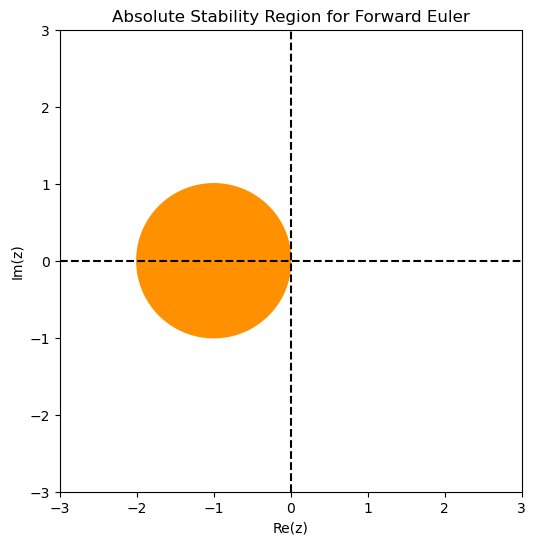

In [8]:
# Plot the region of absolute stability for Forward Euler
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)

t = numpy.linspace(0.0, 2.0 * numpy.pi, 100)

axes.fill(numpy.cos(t) - 1.0, numpy.sin(t), color=(255.0/255.0,145.0/255.0,0/255.0,1.0))
axes.plot([-3, 3],[0.0, 0.0],'k--')
axes.plot([0.0, 0.0],[-3, 3],'k--')
axes.set_xlim((-3, 3.0))
axes.set_ylim((-3,3))
axes.set_aspect('equal')

axes.set_xlabel('Re(z)')
axes.set_ylabel('Im(z)')



axes.set_title("Absolute Stability Region for Forward Euler")
plt.show()

### Using the stability plots to choose a stable $\Delta t$

If you know the spectrum of eigenvalues $\lambda$ for a given problem,  you can plot them on the stability diagram and then find the value of $\Delta t$ such that all $z_i = \lambda_i\Delta t$ are within the stability region.

E.g. consider Euler's method on a single eigenvalue 
$$
    \lambda = -2 + 2i
$$
with modulus $|\lambda| = 2\sqrt{2}$ which  plots outside of the stability region. 

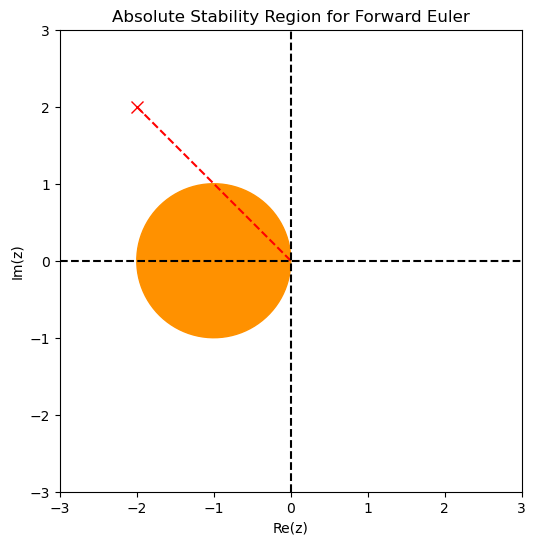

In [9]:
# Plot the region of absolute stability for Forward Euler
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)

lam = (-2,2)
t = numpy.linspace(0.0, 2.0 * numpy.pi, 100)

axes.fill(numpy.cos(t) - 1.0, numpy.sin(t), color=(255.0/255.0,145.0/255.0,0/255.0,1.0))
axes.plot(lam[0],lam[1],'rx',markersize=8)
axes.plot((lam[0], 0.), (lam[1], 0.), 'r--')
axes.plot([-3, 3],[0.0, 0.0],'k--')
axes.plot([0.0, 0.0],[-3, 3],'k--')
axes.set_xlim((-3, 3.0))
axes.set_ylim((-3,3))
axes.set_aspect('equal')

axes.set_xlabel('Re(z)')
axes.set_ylabel('Im(z)')



axes.set_title("Absolute Stability Region for Forward Euler")
plt.show()

However $z=\lambda\Delta t$ so 
$$|z|=\Delta t|\lambda|$$

Thus absolute stability requires that we find a time-step such that $|1 + z| < 1$. If we just look for the intersection with the boundaries of the stability region

$$
\begin{align}
    | 1 +z| &= | 1 +\Delta t(-2+2i) | = 1\\
    & = \sqrt{ (1-2\Delta t)^2 + 4\Delta t^2} = 1 \\
\end{align}
$$ 

implies (after a little work) that 

$$
    \Delta t(2\Delta t - 1) = 0
$$
or $\Delta t \in (0, 1/2)$

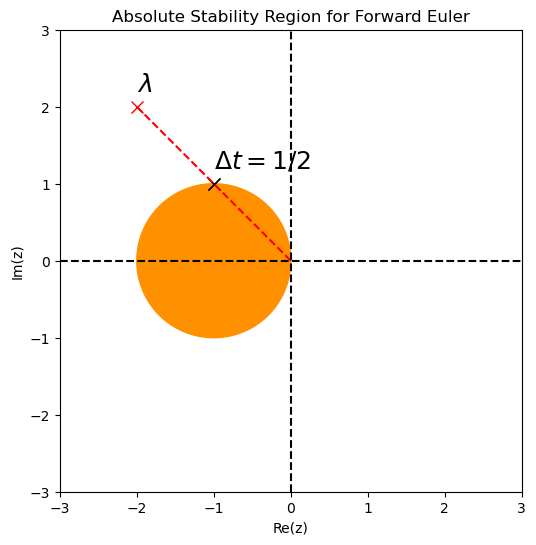

In [10]:
# Plot the region of absolute stability for Forward Euler
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)

lam = (-2,2)
t = numpy.linspace(0.0, 2.0 * numpy.pi, 100)

axes.fill(numpy.cos(t) - 1.0, numpy.sin(t), color=(255.0/255.0,145.0/255.0,0/255.0,1.0))
axes.plot(lam[0],lam[1],'rx',markersize=8)
axes.text(lam[0],1.1*lam[1], '$\lambda$',fontsize=18)
axes.plot(0.5*lam[0],0.5*lam[1],'kx',markersize=8)
axes.plot(0.5*lam[0],0.5*lam[1],'kx',markersize=8)
axes.text(0.5*lam[0],0.6*lam[1], '$\Delta t = 1/2$', fontsize=18)
axes.plot((lam[0], 0.), (lam[1], 0.), 'r--')
axes.plot([-3, 3],[0.0, 0.0],'k--')
axes.plot([0.0, 0.0],[-3, 3],'k--')
axes.set_xlim((-3, 3.0))
axes.set_ylim((-3,3))
axes.set_aspect('equal')

axes.set_xlabel('Re(z)')
axes.set_ylabel('Im(z)')



axes.set_title("Absolute Stability Region for Forward Euler")
plt.show()

### Why complex eigenvalues?  And why should we care?

#### A simple example:  The simple harmonic oscillator

The linear harmonic oscillator can be written as a 2nd-order ODE for position $x$ of a mass on a spring
$$
    \frac{d^2 x}{dt^2} + x = 0, \quad x(0)=x_0,\,  \frac{dx}{dt} = 0.
$$
Which has solutions 
$$
    x(t) = x_0\cos(t)
$$

Alternatively, we can write this as a 2 dimensional system of first order equations by  defining the velocity $v= dx/dt$ and
$$
\begin{align}
    \frac{dx}{dt} &= v \\
    \frac{dv}{dt} &= -x \\
\end{align}
$$ 
or more cleanly as 
$$
    \frac{d\mathbf{u}}{dt} = A\mathbf{u},\quad\mathbf{u}(0)=\mathbf{u_0}
$$
with
$$
\mathbf{u}=\begin{bmatrix} x\\ v\\\end{bmatrix}\quad A= \begin{bmatrix} 0 & 1 \\ -1 & 0 \\ \end{bmatrix}\quad\mathbf{u}_0=\begin{bmatrix} x_0\\ 0\\\end{bmatrix}
$$

All diagonalizable linear dynamical systems have solutions of the form 

$$
    \mathbf{u}(t) = \sum_{i=1}^n c_i e^{\lambda_i t}\mathbf{s}_i
$$ 

where $\lambda_i$, $\mathbf{s}_i$ are corresponding eigenvalues and eigenvectors of $A$ and each eigenvector satisfies

$$
    \frac{d\mathbf{s}_i}{dt} = \lambda_i\mathbf{s}_i
$$

which is exactly our model problem.

In the case where 
$$
A= \begin{bmatrix} 0 & 1 \\ -1 & 0 \\ \end{bmatrix}
$$

The eigenvalues are _ _ _ _ _ _ _ _ ?

Even with complex Eigenvalues and Eigenvectors, the solutions are real and can be shown to be perfect circles on the phase plane 

$$
\begin{align}
    x(t) &= \cos(t)\\
    v(t) &=-\sin(t)\\
\end{align}
$$

However,  the plotting the eigenvalues on the stability diagram show's that Euler's method will be completely unstable for this problem for all time steps $\Delta t$

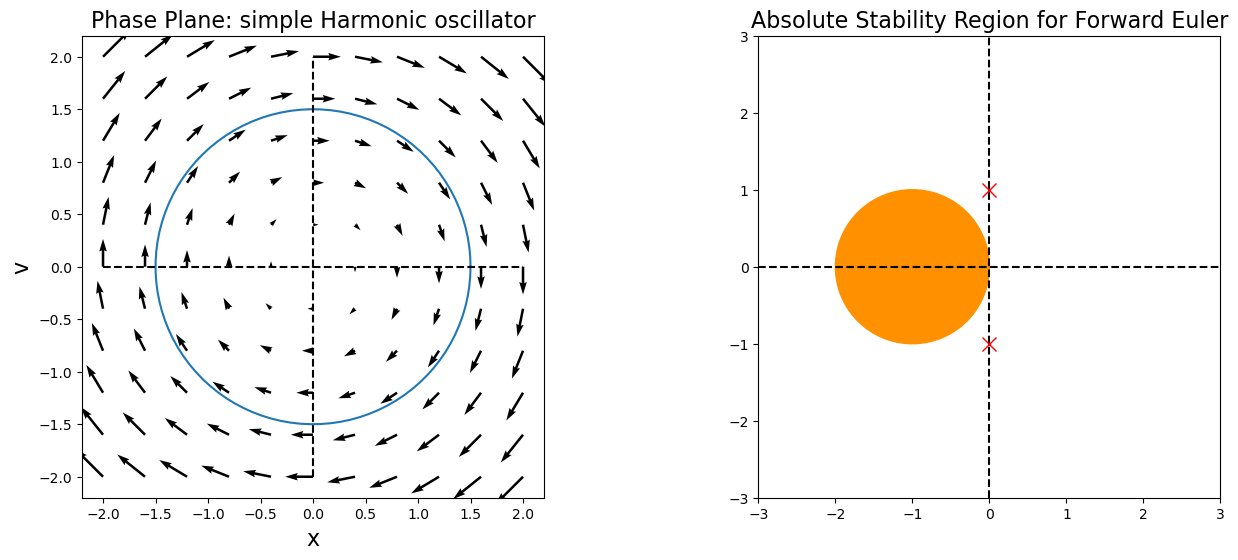

In [11]:
# Plot the region of absolute stability for Forward Euler
x = numpy.linspace(-2, 2, 11)
v = numpy.linspace(-2, 2, 11)
X,V = numpy.meshgrid(x,v)
t = numpy.linspace(0.0, 2.0 * numpy.pi, 100)




fig = plt.figure(figsize=(16,6))
axes = fig.add_subplot(1,2,1)
axes.quiver(X, V, V, -X)
axes.plot(1.5*numpy.cos(t), -1.5*numpy.sin(t))
axes.plot([-2, 2],[0.0, 0.0],'k--')
axes.plot([0.0, 0.0],[-2, 2],'k--')
axes.set_xlabel('x',fontsize=16)
axes.set_ylabel('v',fontsize=16)

axes.set_title('Phase Plane: simple Harmonic oscillator',fontsize=16)
axes.set_aspect('equal')

axes = fig.add_subplot(1, 2, 2)
axes.fill(numpy.cos(t) - 1.0, numpy.sin(t), color=(255.0/255.0,145.0/255.0,0/255.0,1.0))
axes.plot([-3, 3],[0.0, 0.0],'k--')
axes.plot([0.0, 0.0],[-3, 3],'k--')
axes.plot([0., 0.0], [-1., 1.],'rx',markersize=10)
axes.set_xlim((-3, 3.0))
axes.set_ylim((-3,3))
axes.set_aspect('equal')

axes.set_title("Absolute Stability Region for Forward Euler",fontsize=16)
plt.show()

In [12]:
f = lambda t, u : numpy.array([ u[1], -u[0]])
t_span = [0., 4*numpy.pi]
u_0 = numpy.array([1., 0.])
N = 100
t, u = euler(f,t_span,u_0, N)

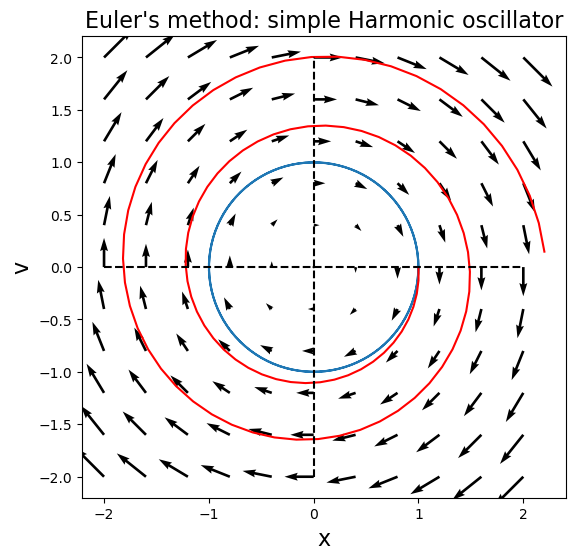

In [13]:
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1,1,1)
axes.quiver(X, V, V, -X)
axes.plot(1.*numpy.cos(t), -numpy.sin(t))
axes.plot(u[0],u[1],'r')
axes.plot([-2, 2],[0.0, 0.0],'k--')
axes.plot([0.0, 0.0],[-2, 2],'k--')
axes.set_xlabel('x',fontsize=16)
axes.set_ylabel('v',fontsize=16)

axes.set_title("Euler's method: simple Harmonic oscillator", fontsize=16)
axes.set_aspect('equal')    

### Absolute Stability of Single-Step Multi-Stage schemes -- The R method

This approach can be applied to **all** Single-Step Multi-Stage schemes including all the Runge-Kutta and Taylor Series methods.  The recipe is straightforward

*  Apply the stepping scheme for one step of the model problem $u' = \lambda u$, $u(0)=u_0$ assuming complex $\lambda$
*  This will result in a discrete approximation

$$
    U(\Delta t) = R(z) U_0
$$

where $z=\lambda\Delta t\in\mathbb{C}$, which will be a discrete approximation to the true solution

$$
    U(\Delta t) = e^{z} U_0
$$
* Absolute stability will require that $|R(z)| < 1$

### Absolute Stability of the backward Euler Method

Now try this on backward Euler.

$$
    U_{n+1} = U_n + \Delta t f(t_{n+1}, U_{n+1}).
$$

which for our model problem is

$$
    U_{n+1} = U_n + \Delta t\lambda U_{n+1}
$$
or 

$$
    (1 - \Delta t\lambda) U_{n+1} = U_n
$$

or rearranging and solving for $U_{n+1}$ gives

$$ 
\begin{align}
    U_{n+1} &= \frac{1}{1-\Delta t\lambda} U_n\\
            &= \frac{1}{1-z}U_n\\
\end{align}
$$

so
$$
    R(z) = \frac{1}{1-z}
$$ 
and absolute stability requires 

$$
    |R(z)| \leq 1 \leftrightarrow |1 - z| \geq 1$$

so in fact the stability region encompasses the entire complex plane except for a circle centered at $(1, 0)$ of radius 1 implying that the backward Euler method is in fact stable for any choice of $\Delta t$ for $\lambda<0$ (and even some positive values of $\lambda$.

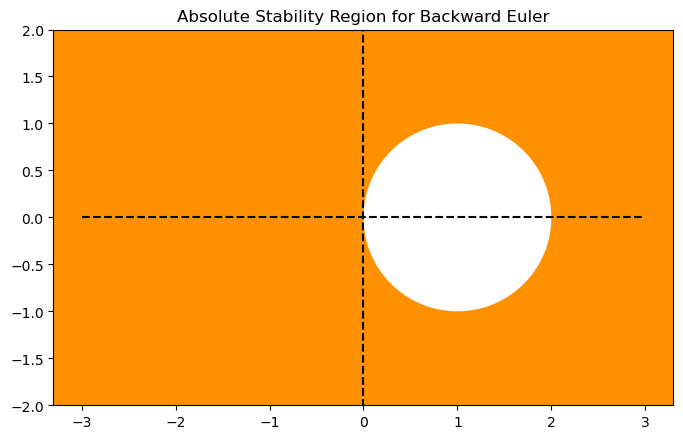

In [14]:
# Plot the region of absolute stability for Backward Euler
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)

t = numpy.linspace(0.0, 2.0 * numpy.pi, 100)

axes.set_facecolor((255.0/255.0,145.0/255.0,0/255.0,1.0))
axes.fill(numpy.cos(t) + 1.0, numpy.sin(t), 'w')
axes.plot([-3, 3],[0.0, 0.0],'k--')
axes.plot([0.0, 0.0],[-3, 3],'k--')
# axes.set_xlim((-3, 1))
axes.set_ylim((-2,2))
axes.set_aspect('equal')

axes.set_title("Absolute Stability Region for Backward Euler")
plt.show()

However, stability doesn't imply accuracy either.  In this case, backwards Euler will still fail after long times for the simple harmonic oscillator as well as it will damp towards zero.  For the general Linear autonomous dynamical system

$$
    \frac{d\mathbf{u}}{dt} = A\mathbf{u}, \quad \mathbf{u}(0) = \mathbf{u}_0
$$

Backwards Euler method can be written as

$$
        \mathbf{U}_{n+1} = \mathbf{U}_n + \Delta t A\mathbf{U}_{n+1}
$$

or rearranging, requires solving the linear algebraic problem at each step

$$
    (I - \Delta t A)\mathbf{U}_{n+1} = \mathbf{U}_n
$$

In [15]:
# Implement Backwards Euler for a linear system $u' = Au$
def beuler(A, t_span, u0, N):
    """ simple implementation of constant step-size forward euler method for vector valued f
        This doc string should have so much more in it
    """
    t = numpy.linspace(t_span[0], t_span[1],N)
    delta_t = t[1] - t[0]

    u = numpy.empty((len(t),len(u0)))
    B = numpy.eye(len(u0)) - delta_t*A
    u[0] = u0
    for (n, t_n) in enumerate(t[:-1]):
        u[n + 1] = numpy.linalg.solve(B,u[n])
    return t, u.transpose()

In [16]:
A = numpy.array([[0, 1], [-1, 0]])
t_span = [0., 4*numpy.pi]
u_0 = numpy.array([1., 0.])
N = 10000
t, u = beuler(A,t_span,u_0, N)

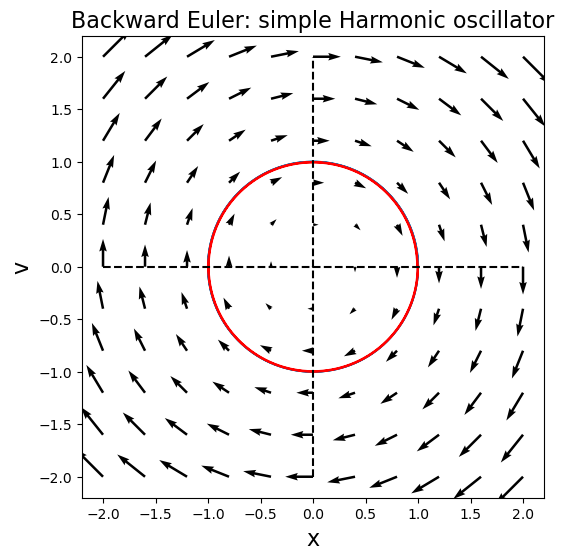

In [17]:
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1,1,1)
axes.quiver(X, V, V, -X)
axes.plot(1.*numpy.cos(t), -numpy.sin(t))
axes.plot(u[0],u[1],'r')
axes.plot([-2, 2],[0.0, 0.0],'k--')
axes.plot([0.0, 0.0],[-2, 2],'k--')
axes.set_xlabel('x',fontsize=16)
axes.set_ylabel('v',fontsize=16)

axes.set_title("Backward Euler: simple Harmonic oscillator", fontsize=16)
axes.set_aspect('equal')    

## General Stability Regions for Linear Methods

We can also map out  stability regions for Linear Multi-step methods (although the analysis is slightly more complicated).

All of the Linear Multi-step methods from the previous lecture can be written
$$
    \sum^r_{j=0} \alpha_j U_{n+j} = \Delta t \sum^r_{j=0} \beta_j f(t,U_{n+j})
$$

which for our model problem, $f(t,u) = \lambda u$ becomes
$$
    \sum^r_{j=0} \alpha_j U_{n+j} = \Delta t \sum^r_{j=0} \beta_j \lambda U_{n+j}
$$

or  rearranging and again defining $z=\Delta t\lambda$ becomes

$$
    \sum^r_{j=0} (\alpha_j - \beta_j z) U_{n+j} = 0.
$$
which takes the form of a "Linear Difference Equation"

### Characteristic Polynomials and Linear Difference Equations

To help us analyze stability regions we need to take a small aside and consider linear difference equations and their solutions.  Say we wanted to solve

$$\sum^r_{j=0} \alpha_j U_{n+j} = 0$$

given initial conditions $U_0, U_1, \ldots, U_{r-1}$.  This expression has a solution in the general form $U_n = \xi^n$.  

Plugging this into the equation we have

$$\sum^r_{j=0} \alpha_j \xi^{n+j} = 0$$

which simplifies to

$$\sum^r_{j=0} \alpha_j \xi^j = 0 $$

by dividing by $\xi^n$.  If $\xi$ then is a root of the polynomial

$$\rho(\xi) \equiv \sum^r_{j=0} \alpha_j \xi^j$$

then $\xi$ solves the original difference equation.

### Example:  the Fibonacci Numbers

A classic example of  linear difference equation is the Fibonnacci sequence, $0,1,1,2,3,5,\ldots$. 

Which are solutions to the two-term difference equation

$$
    U_{n+2} = U_{n+1} + U_n, \quad U_0=0,\, U_1 = 1
$$

or

$$
    U_{n+2} - U_{n+1} - U_n = 0
$$

or $\alpha = \begin{bmatrix} -1 & -1 & 1 \\\end{bmatrix}$

Substituting $U_n = \xi^n$ into 
$$
U_{n+2} - U_{n+1} - U_n =0
$$
yields
$$
    \xi^n\left(\xi^2 - \xi -1\right) = 0
$$
which has solutions $\xi =  \frac{1\pm\sqrt{5}}{2}$.  Where the positive root is our favorite number $\phi=1.618033$ which is the golden ratio.  The negative root is $1-\phi$. Note, these roots are related to the eigenvalues of a related problem

Thus all Fibonacci numbers can be written as a linear combination of the two roots

$$
    U_n = A\phi^n + B(1-\phi)^n
$$

where $A$ and $B$ are determined by the first two terms in the sequence [0,1].

Note, in this case $\phi > 1$ (while $|(1-\phi)|<1$) thus $U_n\rightarrow\infty$ as $n\rightarrow\infty$.

### Stability for LMM's
Anyway,  Back to the Linear difference equations arising from applying any Linear multistep method to the model problem
$$
    \sum^r_{j=0} (\alpha_j - \beta_j z) U_{n+j} = 0.
$$

Letting
$$
    \rho(\xi) = \sum^r_{j=0} \alpha_j \xi^j, \quad \sigma(\xi) = \sum^r_{j=0} \beta_j \xi^j
$$
and substituting $U_n = \xi^n$ into the difference equations reduces to 
$$
    \pi(\xi, z) = \rho(\xi) - z \sigma(\xi) = 0
$$
where $\pi(\xi, z)$ is the **stability polynomial** of the method, whose roots are solutions of the difference method.

### Absolute stability of the linear multi-step methods

For $U_n$ to stay bounded as $n\rightarrow\infty$,  it requires that all roots $\xi_i$ of $\pi(\xi, z)$ satisfy
$$
    |\xi_i| \leq 1
$$
If this is the case, then the multi-step method is **zero-stable**.  Roughly you can think of these roots as multiplying the past truncation errors so that if they are less than or equal to 1 they do not grow in magnitude.  We then define the region of **absolute stability** as the values for $z$ for which this is true.  This approach reduces to the $R$ method for  one-step methods as a special case.

### Example:  Forward Euler's Method

Examining forward Euler's method we have

$$\begin{aligned}
    0 &= U_{n+1} - U_n - \Delta t \lambda U_n \\
    &= U_{n+1} - U_n (1 + \Delta t \lambda)\\
\end{aligned}
$$

setting $U_n = \xi^n$ implies
$$
\begin{aligned}
   0 &= \xi^n\left(\xi -  (1 + z)\right)\\
\end{aligned}$$

or $\pi(\xi, z) = \xi -  (1 + z)$ whose root is $\xi = 1 + z$ and we have re-derived the stability region we had found before.

### Example:  Backwards Euler's Method

Similarly for backwards Euler

$$\begin{aligned}
    0 &= U_{n+1} - U_n - \Delta t \lambda U_{n+1} \\
    &= U_{n+1}(1 - \Delta t\lambda) - U_n \\
    &= \xi(1 - z)  - 1 \\
    &=\pi(\xi, z)
\end{aligned}$$

whose root is $\xi = 1/(1 - z)$  

### Example: Adams-Bashforth 2

As an example consider the Adams-Bashforth 2-stage LMM
$$
    U_{n+2} = U_{n+1} + \frac{\Delta t}{2} (-f(U_n) + 3 f(U_{n+1}))
$$

Let $f(U) = \lambda U$,  $z = \Delta t \lambda$

$$
    U_{n+2} - U_{n+1} - \frac{1}{2} (-z U_n + 3 z U_{n+1}) = 0 \\
$$


substituting $U_n=\xi^n$, and factoring out $\xi^n$ yields
$$
    \pi(\xi, z) = \xi^{2} - \xi - \frac{1}{2} (-z  + 3 z \xi)
$$
with roots when

$$
     2 \xi^2 - (2 + 3z) \xi + z =0
$$


## Plotting Stability Regions

Given a stability polynomial $\pi(\xi,z)$, absolute stability requires that 

$$
    \max{|\xi_i|} <= 1
$$
where $\xi_i$ are the (generally complex) roots of $\pi(\xi, z)$ and therefore a function of $z$.  In the case of single step schemes, the problem reduces to finding the region of the complex plane where $|R(z)| < 1$.  

Either way,  the simplest way to visualize the regions of the complex plane where the scheme is stable, is to calculate either $|R(z)|$ or $\max|\xi_i(z)|$ and plot the 1-contour and determine all regions that are $<1$.

### Some useful codes

study the following cells for some useful routines for plotting stability regions for both Single-step multi-stage schemes and Linear Multi-step schemes

In [18]:
def stability_plot(X, Y, C, axes, title=None, continuous=True):
    """
    Utility function to make stability diagram given complex stability scalar C
    
    parameters:
    -----------
    
    X, Y:  numpy.meshgrids for complex plane
    C: numpy array
        Field to plot,  either |R(z)| for a single step scheme, or max(|xi_i(z)|) for a LMM scheme
    axes: matplotlib axes object
        subplot or plot to draw in. 
    title: string
        subplot title if not None 
    continuous: boolean
        if True, plot a continous coloring of C
        if False, plot Heaviside(C)
    """
    if  continuous:
        Ch = C
    else:
        Ch = numpy.heaviside(C-1,0.)
    pcolor_plot = axes.pcolor(X, Y, Ch, vmin=0, vmax=1, cmap=plt.get_cmap('Greens_r'), shading='auto')
    axes.contour(X, Y, C, 'k', levels=[1.0])
    fig = plt.gcf()
    fig.colorbar(pcolor_plot)
    axes.plot(x, numpy.zeros(x.shape),'k--')
    axes.plot(numpy.zeros(y.shape), y,'k--')
    
    axes.set_xlabel('Re', fontsize=16)
    axes.set_ylabel('Im', fontsize=16)
    if title is not None:
        axes.set_title(title, fontsize=16)
    
    axes.set_aspect('equal')    
    
def plot_stability_ssms(R, x, y, axes=None, title=None, continuous=True):
    """ 
    plot stability regions for single-step multi-stage ODE schemes given the function R(z)
    such that U_{n+1} = R(z)U_n   and z is complex
    
    parameters:
    -----------
    
    R: calleable
        function of a complex variable z such that if |R|<=1, the scheme is absolutely stable
    x: numpy array
        array of values for the real axis
    y: numpy array
        values to plot for the imaginary axis
    axes: matplotlib axes object
        subplot or plot to draw in.  If axes=None create a new figure
    title: string
        subplot title if 
    continuous: boolean
        if True, plot a continous coloring of C
        if False, plot Heaviside(C)
    """
    
    X,Y = numpy.meshgrid(x,y)
    Z = X + 1j * Y
    if axes is None:
        fig = plt.figure(figsize=(8,6))
        axes = fig.add_subplot(1,1,1)
    
    abs_R = numpy.abs(R(Z))
    stability_plot(X, Y, abs_R, axes, title, continuous)
    
def plot_stability_lmm(pi_coeff, x, y, axes=None, title=None, continuous=True):
    """ 
    plot stability regions for linear multi-step  ODE schemes given the coefficients of the stability polynomial
    pi(xi, z)
    
    parameters:
    -----------
    
    pi_coeff: calleable (function of z)
        function that returns array of stability polynomial pi(z)
    x: numpy array
        array of values for the real axis
    y: numpy array
        values to plot for the imaginary axis
    axes: matplotlib axes object
        subplot or plot to draw in.  If axes=None create a new figure
    title: string
        subplot title if not None   
    continuous: boolean
        if True, plot a continous coloring of C
        if False, plot Heaviside(C)
    """
       
    X,Y = numpy.meshgrid(x,y)
    Z = X + 1j * Y
    if axes is None:
        fig = plt.figure(figsize=(8,6))
        axes = fig.add_subplot(1,1,1)
    
    norm_max = numpy.empty(Z.shape)
    for i,row in enumerate(Z):
        for j, z in enumerate(row):
            norm_max[i,j] = max(numpy.abs(numpy.roots(pi_coeff(z))))
    
    stability_plot(X, Y, norm_max, axes, title, continuous)
    

In [19]:
x = numpy.linspace(-3,3,100)
y = numpy.linspace(-3,3,100)

R_euler = lambda z: 1 + z
R_beuler = lambda z: 1./(1. - z)
R_trap = lambda z: (1. + 0.5*z)/(1. - 0.5*z)
R_RK2 = lambda z: 1 + z + z**2/2
R_Taylor4 = lambda z: 1 + z + z**2/2 + z**3/6. + z**4/24.

continuous=True

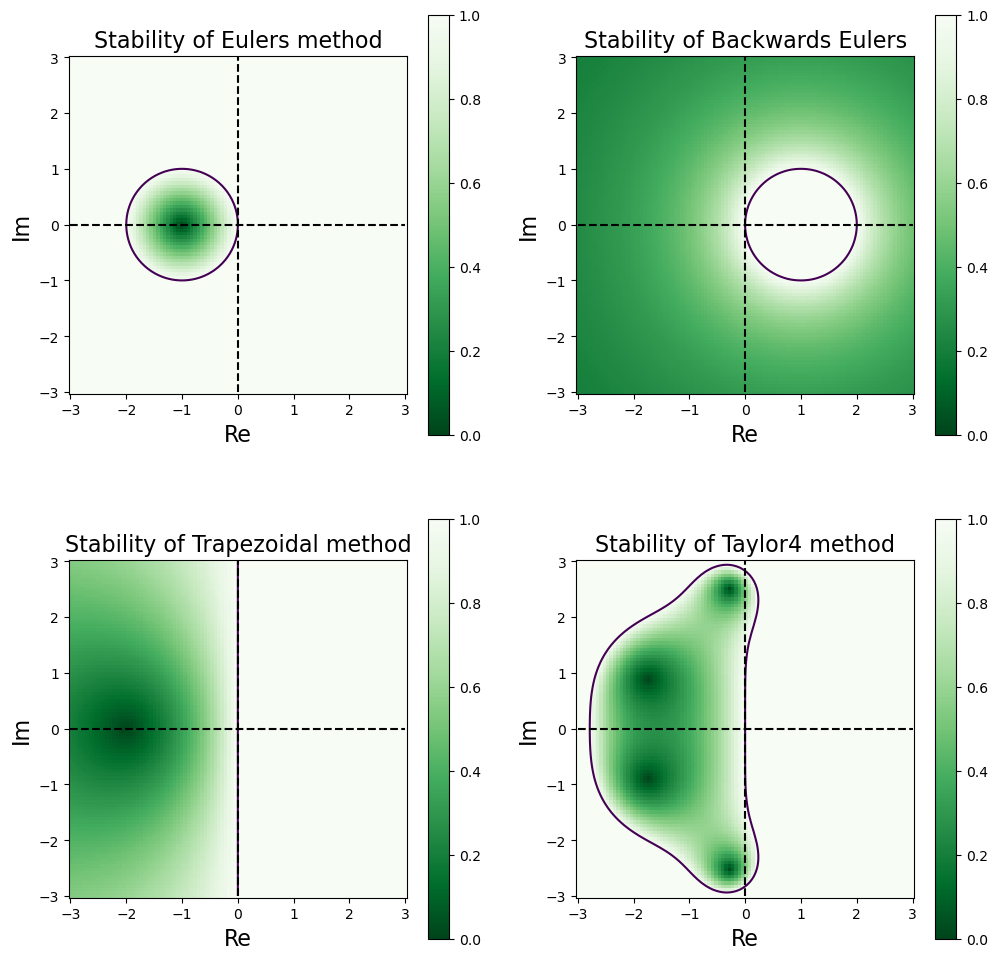

In [20]:
fig = plt.figure(figsize=(12,12))
axes = fig.add_subplot(2,2,1)
plot_stability_ssms(R_euler, x, y, axes=axes, title='Stability of Eulers method', continuous=continuous)

axes = fig.add_subplot(2,2,2)
plot_stability_ssms(R_beuler, x, y, axes=axes, title='Stability of Backwards Eulers', continuous=continuous)

axes = fig.add_subplot(2,2,3)
plot_stability_ssms(R_trap, x, y, axes=axes, title='Stability of Trapezoidal method', continuous=continuous)

axes = fig.add_subplot(2,2,4)
plot_stability_ssms(R_Taylor4, x, y, axes=axes, title='Stability of Taylor4 method', continuous=continuous)


In [21]:
x = numpy.linspace(-3,3,100)
y = numpy.linspace(-3,3,100)

pi_euler = lambda z: numpy.array([1., -(1 + z)])
pi_AB2 = lambda z: numpy.array([2, -(2. + 3*z), z])

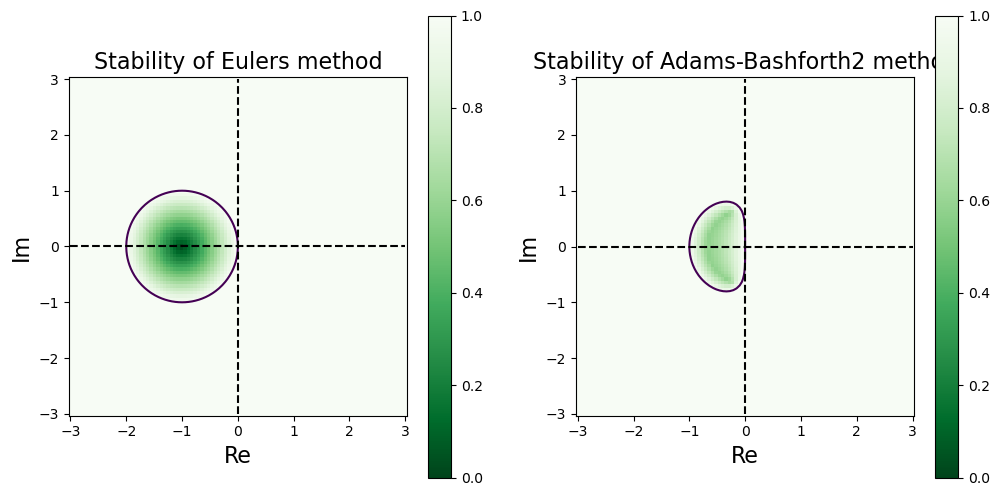

In [22]:
fig = plt.figure(figsize=(12,6))
axes = fig.add_subplot(1,2,1)
plot_stability_lmm(pi_euler, x, y, axes=axes, title='Stability of Eulers method')
axes = fig.add_subplot(1,2,2)
plot_stability_lmm(pi_AB2, x, y, axes=axes, title='Stability of Adams-Bashforth2 method')

## Application to Stiff ODEs

Consider  the ODE IVP 

$$u'(t) = \lambda (u - \cos t) - \sin t,\quad u(t_0)=u_0$$

The general solution of the ODE is

$$u(t) = e^{\lambda (t - t_0)} (u_0 - \cos t_0) + \cos t$$

For $u_0=1$ at $t_0=0$,  the solution is simply $\cos t$

What happens to solutions that are slightly different from $u_0 = 1$ or $t_0 = 0$? 

$$u(t) = e^{\lambda (t - t_0)} (u_0 - \cos t_0) + \cos t$$

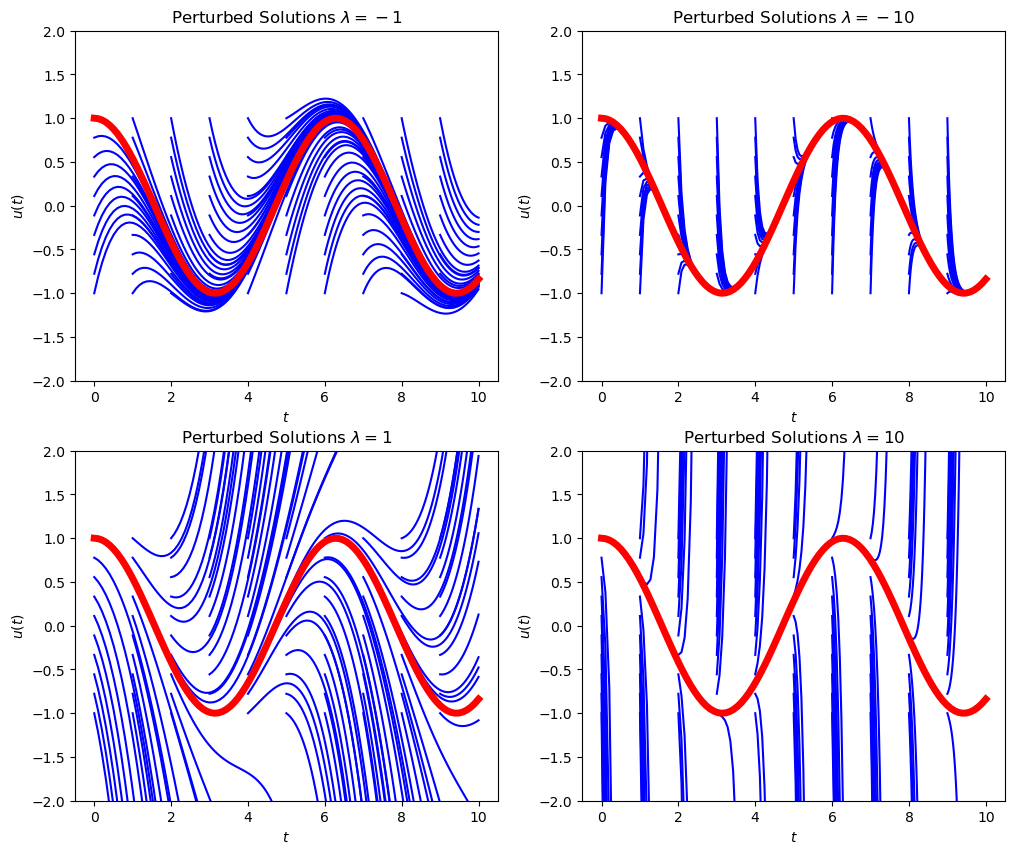

In [23]:
# Plot "hairy" solutions to the ODE
u = lambda t_0, u0, lam, t: numpy.exp(lam * (t - t_0)) * (u0 - numpy.cos(t_0)) + numpy.cos(t)

fig = plt.figure(figsize=(12, 10))

for i,lam in enumerate([-1, -10, 1, 10]):
    axes = fig.add_subplot(2, 2, i+1)
    for u0 in numpy.linspace(-1, 1, 10):
        for t_0 in numpy.linspace(0.0, 9.0, 10):
            t = numpy.linspace(t_0,10.0,100)
            axes.plot(t, u(t_0, u0, lam, t),'b')
    t = numpy.linspace(0.0,10.0,100)
    axes.plot(t, numpy.cos(t), 'r', linewidth=5)
    axes.set_ylim((-2, 2))
        
    axes.set_title("Perturbed Solutions $\lambda = %s$" % lam)
    axes.set_xlabel('$t$')
    axes.set_ylabel('$u(t)$')
axes.set_ylim((-2, 2))
plt.show()
        

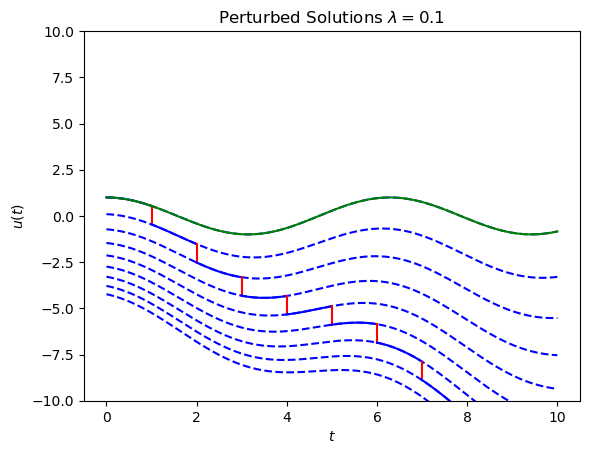

In [24]:
# Plot "inverse hairy" solutions to the ODE
u = lambda t_0, u0, lam, t: numpy.exp(lam * (t - t_0)) * (u0 - numpy.cos(t_0)) + numpy.cos(t)

num_steps = 10
error = numpy.ones(num_steps) * 1.0
t_hat = numpy.linspace(0.0, 10.0, num_steps + 1)
t_whole = numpy.linspace(0.0, 10.0, 1000)

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
eta = 1.0
lam = 0.1

for n in range(1,num_steps):
    t = numpy.linspace(t_hat[n-1], t_hat[n], 100)
    U = u(t_hat[n-1], eta, lam, t)
    axes.plot(t, U, 'b')
    axes.plot(t_whole, u(t_hat[n-1], eta, lam, t_whole),'b--')
    axes.plot([t[-1], t[-1]], (U[-1], U[-1] + -1.0**n * error[n]), 'r')
    eta = U[-1] + -1.0**n * error[n]

t = numpy.linspace(0.0, 10.0, 100)
axes.plot(t, numpy.cos(t), 'g')

axes.set_title("Perturbed Solutions $\lambda = %s$" % lam)
axes.set_xlabel('$t$')
axes.set_ylabel('$u(t)$')
axes.set_ylim((-10,10))
plt.show()
        

### Example:  Chemical systems

Consider the transition of a chemical $A$ to a chemical $C$ through the process

$$A \overset{K_1}{\rightarrow} B \overset{K_2}{\rightarrow} C.$$

We can write this problem as a system of Linear ODE's
$$
\begin{align*}
    \frac{dA}{dt} &= -K_1 A\\
    \frac{dB}{dt} &= K_1 A -K_2B\\
    \frac{dC}{dt} &= K_2B\\
\end{align*}
$$
with initial condition $A_0, B_0, C_0$

    

If we let

$$\mathbf{u} = \begin{bmatrix} A \\ B \\ C \end{bmatrix}$$

then we can rewrite this as a linear dynamical system
$$
 \frac{d\mathbf{u}}{dt} = M\mathbf{u},  \quad \mathbf{u}(0) = \mathbf{u}_0
$$ 
where 

$$ M = 
\begin{bmatrix}
    -K_1 & 0 & 0 \\
    K_1 & -K_2 & 0 \\
    0 & K_2 & 0
\end{bmatrix} 
$$

If $A$ is diagonalizable, the general solution of a linear dynamical system  can be written in terms of the eigenvalues ($\lambda_i$) and eigenvectors $\mathbf{x}_i$ of $M$ as

$$\mathbf{u}(t) = c_{1} e^{\lambda_1 t}\mathbf{x}_1 + c_{2}e^{\lambda_2t}\mathbf{x}_2 + c_{3}e^{\lambda_3t}\mathbf{x}_3$$

And given our matrix 
$$ M = 
\begin{bmatrix}
    -K_1 & 0 & 0 \\
    K_1 & -K_2 & 0 \\
    0 & K_2 & 0
\end{bmatrix} 
$$

The eigenvalues are ??

And the general solution is 

$$\mathbf{u}(t) = c_{1} e^{-K_1t}\mathbf{x}_1 + c_{2}e^{-K_2t}\mathbf{x}_2 + c_{3}\mathbf{x}_3$$

and the constants $c_i$ can be found by solving $X\mathbf{c} = \mathbf{u}_0$ which describe the initial condition as a linear combination of the eigenvectors.

In [25]:
# Solve the chemical systems example using a Forward Euler scheme
# Problem parameters
K_1 = 1
K_2 = 90.
N =  1000


A = numpy.array([[-K_1, 0, 0], [K_1, -K_2, 0], [0, K_2, 0]])
f = lambda u: numpy.dot(A, u)
u_0 = [3, 5.0, 0.0]
t_span = [0, 3.]

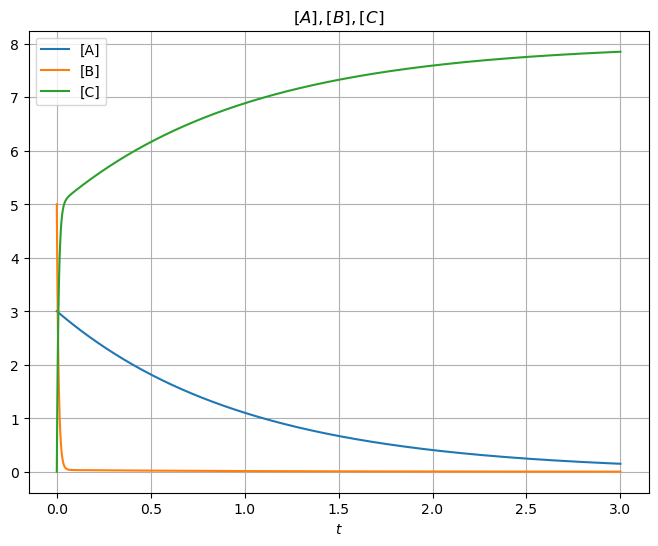

In [26]:
f = lambda t, u : A.dot(u)
t, U = euler(f, t_span, u_0, N)

fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)

axes.plot(t, U.transpose())
axes.legend(["[A]", "[B]", "[C]"])
axes.set_title("Chemical System")
axes.set_xlabel("$t$")
axes.set_title("$[A], [B], [C]$")
#axes.set_ylim((0.0, 10.))
#axes.set_xlim((0.0, 2.0))
axes.grid()

plt.show()

### What is stiffness?

In general a **stiff** ODE is one where $u'(t) \ll f'(t, u)$.  For linear dynamical systems like the chemical decay problem,  the **stiffness ratio**

$$\frac{\max_p |\lambda_p|}{\min_p |\lambda_p|}$$

can be used to characterize the stiffness of the system.  In our last example this ratio was $K_2 / K_1$ if $K_2 > K_1$.  As we increased this ratio we observed that the numerical method became unstable only a reduction in $\Delta t$ lead to stable solution again.  For explicit time step methods this is problematic as the reduction of the time step for only one of the species leads to very expensive evaluations.  For example, forward Euler has the stability criteria

$$|1 + \Delta t \lambda| < 1$$

where $\lambda$ will have to be the maximum eigenvalue of the system.  

In [27]:
# set the eigenvalues and time step
K_1 = 1.0
K_2 = 3.0
delta_t = 1.0
eigenvalues = [-K_1, -K_2]


z = -1.0
z = -3.0


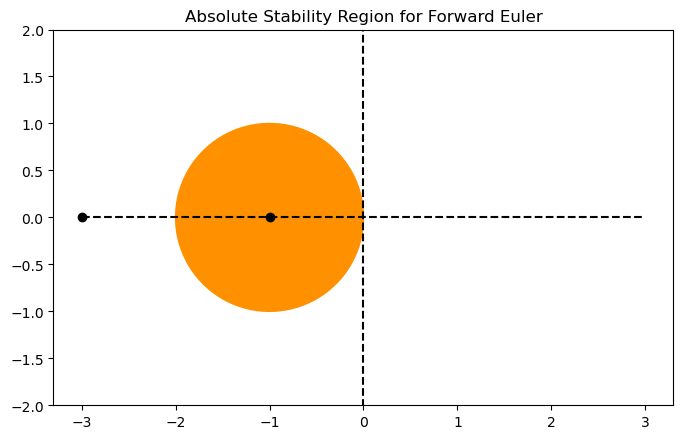

In [28]:
# Plot the region of absolute stability for Forward Euler
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)

t = numpy.linspace(0.0, 2.0 * numpy.pi, 100)


axes.fill(numpy.cos(t) - 1.0, numpy.sin(t), color=(255.0/255.0,145.0/255.0,0/255.0,1.0))
for lam in eigenvalues:
    print('z = {}'.format(lam * delta_t))
    axes.plot(lam * delta_t, 0.0, 'ko')
axes.plot([-3, 3],[0.0, 0.0],'k--')
axes.plot([0.0, 0.0],[-3, 3],'k--')
# axes.set_xlim((-3, 1))
axes.set_ylim((-2,2))
axes.set_aspect('equal')

axes.set_title("Absolute Stability Region for Forward Euler")
plt.show()

In [29]:
# solve using backwards Euler
K_1 = 1.0
K_2 = 100.0
A = numpy.array([[-K_1, 0, 0], [K_1, -K_2, 0], [0, K_2, 0]])

N = 10000 
t_span = [0., 3.]
U0 = [3., 5.0, 0.]

t, U = beuler(A, t_span, U0, N)


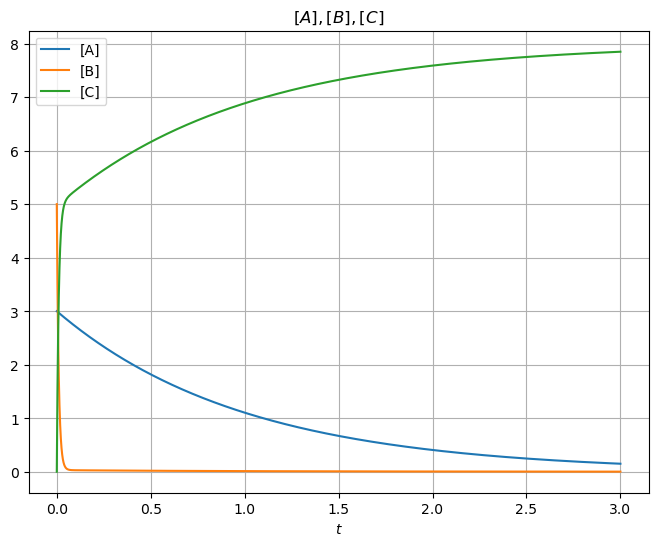

In [30]:
    
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)

axes.plot(t, U.T)
axes.legend(["[A]", "[B]", "[C]"])
axes.set_title("Chemical System")
axes.set_xlabel("$t$")
axes.set_title("$[A], [B], [C]$")
axes.grid()

plt.show()

### A-Stability
What if we could expand the absolute stability region to encompass more of the left-half plane or even better, all of it.  A method that has this property is called **A-stable**.  We have already seen one example of this with backward Euler which as a stability region of

$$|1 - z| \geq 1$$

which covers the full left-half plane.  It turns out that for linear multi-step methods a theorem by Dahlquist proves that there are no LMMs that satisfies the A-stability criterion beyond second order (trapezoidal rule).  There are higher-order Runge-Kutta methods do however.

Perhaps this is too restrictive though.  Often large eigenvalues for systems (for instance coming from a PDE discretization for the heat equation) lie completely on the real line.  If the stability region can encompass as much of the real line as possible while leaving out the rest of the left-half plane we can possibly get a more efficient method.  There are a number of methods that can be constructed that have this property but are higher-order.

-3.0
-1.0


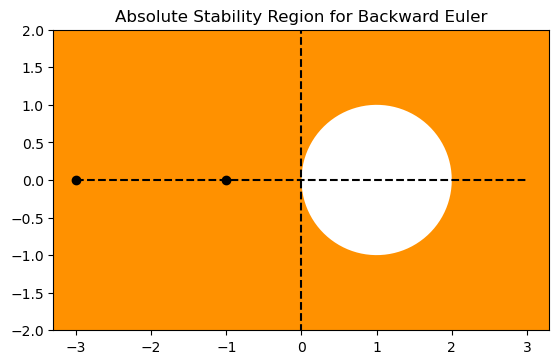

In [31]:
# Plot the region of absolute stability for Backward Euler
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

t = numpy.linspace(0.0, 2.0 * numpy.pi, 100)

K_1 = 3.0
K_2 = 1.0
delta_t = 1.0
eigenvalues = [-K_1, -K_2]

axes.set_facecolor((255.0/255.0,145.0/255.0,0/255.0,1.0))
axes.fill(numpy.cos(t) + 1.0, numpy.sin(t), 'w')
for lam in eigenvalues:
    print(lam * delta_t)
    axes.plot(lam * delta_t, 0.0, 'ko')
axes.plot([-3, 3],[0.0, 0.0],'k--')
axes.plot([0.0, 0.0],[-3, 3],'k--')
# axes.set_xlim((-3, 1))
axes.set_ylim((-2,2))
axes.set_aspect('equal')

axes.set_title("Absolute Stability Region for Backward Euler")
plt.show()

# L-Stability

It turns out not all A-stable methods are alike.  Consider the backward Euler method and the trapezoidal method defined by

$$\frac{U_{n+1} - U_n}{\Delta t} = \frac{1}{2}(f(U_n) + f(U_{n+1}))$$

whose stability polynomial (or $R(z))$ is

$$\begin{aligned}
    0 &= U_{n+1} - U_n - \Delta t \frac{1}{2} (\lambda U_n + \lambda U_{n+1}) \\
      &= U_{n+1}\left(1 - \frac{1}{2} \Delta t \lambda \right ) - U_n \left(1 + \frac{1}{2}\Delta t \lambda \right)\\
\end{aligned}$$

or 
$$
      \pi(\xi,z) = \left(1 - \frac{z}{2}\right ) \xi - \left(1 + \frac{z}{2}\right)
$$ 
with single root
$$
\xi(z) = R(z) = \frac{1 + \frac{z}{2}}{1 - \frac{z}{2}}
$$

which shows that it is A-stable (i.e. $|R(z)| < 1$ for all $\Re(z)<0$)  

### Example

Let's apply both these methods the stiff problem

$$u'(t) = \lambda (u - \cos t) - \sin t,\quad u(t_0)=u_0$$

With solution 

$$u(t) = e^{\lambda (t - t_0)} (u_0 - \cos t_0) + \cos t$$

and see what happens.

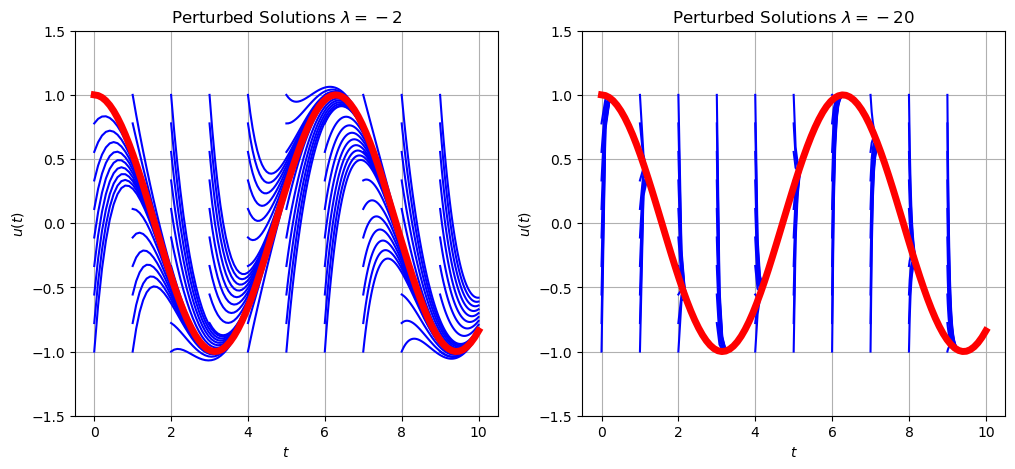

In [32]:
# Plot "hairy" solutions to the ODE
u = lambda t_0, u0, lam, t: numpy.exp(lam * (t - t_0)) * (u0 - numpy.cos(t_0)) + numpy.cos(t)

fig = plt.figure(figsize=(12, 5))

for i,lam in enumerate([-2, -20]):
    axes = fig.add_subplot(1, 2, i+1)
    for u0 in numpy.linspace(-1, 1, 10):
        for t_0 in numpy.linspace(0.0, 9.0, 10):
            t = numpy.linspace(t_0,10.0,100)
            axes.plot(t, u(t_0, u0, lam, t),'b')
    t = numpy.linspace(0.0,10.0,100)
    axes.plot(t, numpy.cos(t), 'r', linewidth=5)
    axes.set_ylim((-1.5, 1.5))
    axes.grid()
        
    axes.set_title("Perturbed Solutions $\lambda = %s$" % lam)
    axes.set_xlabel('$t$')
    axes.set_ylabel('$u(t)$')
axes.set_ylim((-1.5, 1.5))
plt.show()
        

In [33]:
# Compare accuracy between Euler and Trapezoidal for the stiff ODE
f = lambda t, lam, u: lam * (u - numpy.cos(t)) - numpy.sin(t)
u_exact = lambda t_0, eta, lam, t: numpy.exp(lam * (t - t_0)) * (u0 - numpy.cos(t_0)) + numpy.cos(t)

t_0 = 0.0
t_f = 1.0
eta = 2.0
lam = -1e3

In [34]:
num_steps = [10, 20, 40, 50]
# num_steps = numpy.arange(100, 1000, 100)

delta_t = numpy.empty(len(num_steps))
error_euler = numpy.empty(len(num_steps))
error_trap = numpy.empty(len(num_steps))

for (i, N) in enumerate(num_steps):
    t = numpy.linspace(0, t_f, N)
    delta_t[i] = t[1] - t[0]
    u = u_exact(t_0, eta, lam, t_f)
    
    # Compute Euler solution
    U_euler = numpy.empty(t.shape)
    U_euler[0] = eta
    for (n, t_n) in enumerate(t[1:]):
        U_euler[n+1] = (U_euler[n] - lam * delta_t[i] * numpy.cos(t_n) - delta_t[i] * numpy.sin(t_n)) / (1.0 - lam * delta_t[i])
    error_euler[i] = numpy.abs(U_euler[-1] - u) / numpy.abs(u)
    
    # Compute using trapezoidal
    U_trap = numpy.empty(t.shape)
    U_trap[0] = eta
    for (n, t_n) in enumerate(t[1:]):
        U_trap[n+1] = (U_trap[n] + delta_t[i] * 0.5 * f(t_n, lam, U_trap[n]) - 0.5 * lam * delta_t[i] * numpy.cos(t_n) - 0.5 * delta_t[i] * numpy.sin(t_n)) / (1.0 - 0.5 * lam * delta_t[i])
    error_trap[i] = numpy.abs(U_trap[-1] - u)

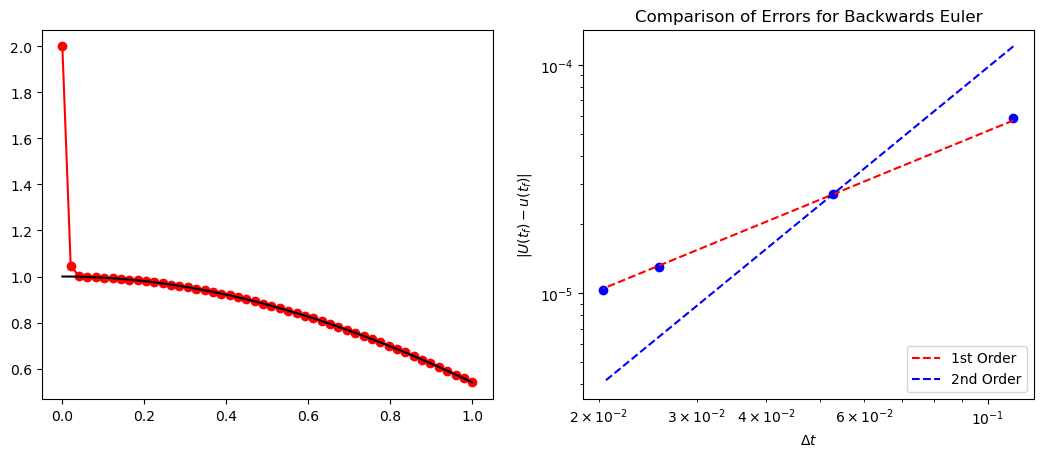

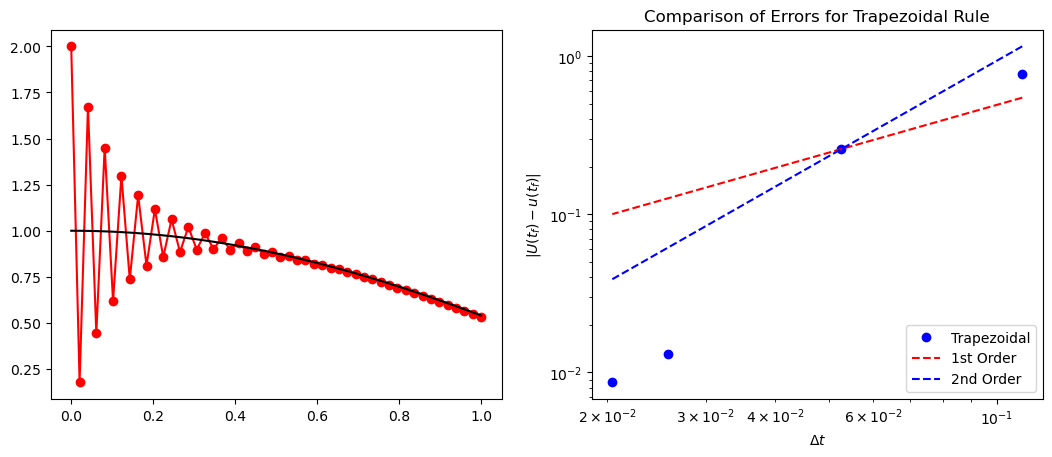

In [35]:
    
# Plot error vs. delta_t
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
axes = fig.add_subplot(1, 2, 1)
axes.plot(t, U_euler, 'ro-')
axes.plot(t, u_exact(t_0, eta, lam, t),'k')

axes = fig.add_subplot(1, 2, 2)
axes.loglog(delta_t, error_euler, 'bo')
order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))
axes.loglog(delta_t, order_C(delta_t[1], error_euler[1], 1.0) * delta_t**1.0, 'r--', label="1st Order")
axes.loglog(delta_t, order_C(delta_t[1], error_euler[1], 2.0) * delta_t**2.0, 'b--', label="2nd Order")

axes.legend(loc=4)
axes.set_title("Comparison of Errors for Backwards Euler")
axes.set_xlabel("$\Delta t$")
axes.set_ylabel("$|U(t_f) - u(t_f)|$")

# Plots for trapezoid
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
axes = fig.add_subplot(1, 2, 1)
axes.plot(t, U_trap, 'ro-')
axes.plot(t, u_exact(t_0, eta, lam, t),'k')

axes = fig.add_subplot(1, 2, 2)
axes.loglog(delta_t, error_trap, 'bo', label='Trapezoidal')
order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))
axes.loglog(delta_t, order_C(delta_t[1], error_trap[1], 1.0) * delta_t**1.0, 'r--', label="1st Order")
axes.loglog(delta_t, order_C(delta_t[1], error_trap[1], 2.0) * delta_t**2.0, 'b--', label="2nd Order")

axes.legend(loc=4)
axes.set_title("Comparison of Errors for Trapezoidal Rule")
axes.set_xlabel("$\Delta t$")
axes.set_ylabel("$|U(t_f) - u(t_f)|$")

plt.show()

It turns out that if we look at a one-step method and define the following ratio

$$U_{n+1} = R(z) U_n$$

we can define another form of stability, called **L-stable**, where we require that the method is A-stable and that

$$\lim_{z \rightarrow \infty} |R(z)| = 0.$$

Turns out that backwards Euler is L-stable while trapezoidal rule is not.

In [36]:
R_beuler = lambda z: 1./(1. - z)
R_trap = lambda z: (1. + 0.5*z)/(1. - 0.5*z)

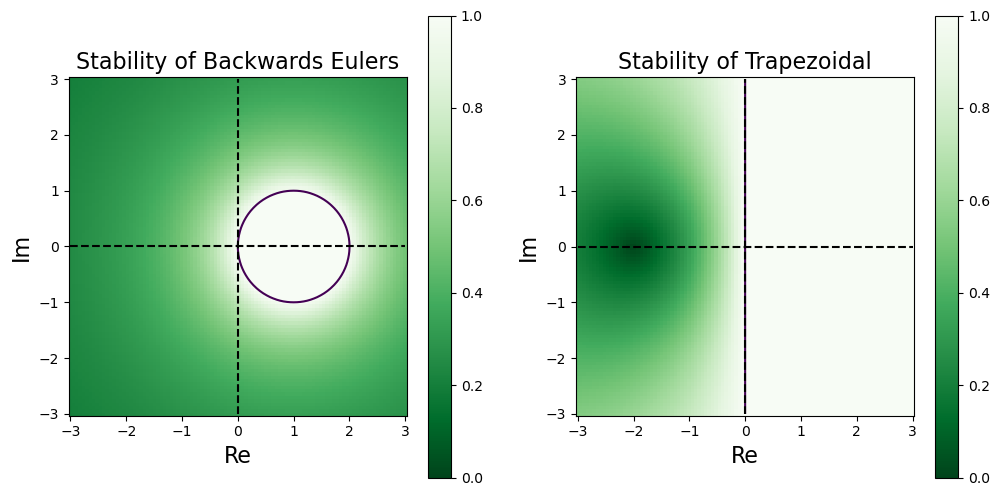

In [37]:
fig = plt.figure(figsize=(12,6))
axes = fig.add_subplot(1,2,1)
plot_stability_ssms(R_beuler, x, y, axes=axes, title='Stability of Backwards Eulers')

axes = fig.add_subplot(1,2,2)
plot_stability_ssms(R_trap, x, y, axes=axes, title='Stability of Trapezoidal')

## Backward Differencing Formulas

A class of LMM methods that are useful for stiff ODE problems are the backward difference formula (BDF) methods which have the form

$$\alpha_0 U_n + \alpha_1 U_{n+1} + \cdots + \alpha_r U_{n+r} = \Delta t\beta_r f(U_{n+r})$$

These methods can be derived directly from backwards finite differences from the point $U_{n+r}$ and the rest of the points back in time.  One can then derive r-step methods that are rth-order accurate this way.  Some of the methods are 

$$\begin{aligned}
    \text{BDF-1}~& (r = 1):& & U_{n+1} - U_n = \Delta t f(U_{n+1}) \\
    \text{BDF-2}~& (r = 2):& &3 U_{n+2} - 4 U_{n+1} + U_n = 2 \Delta t f(U_{n+2}) \\
    \text{BDF-3}~& (r = 3):& &11U_{n+3} - 18U_{n+2} + 9U_{n+1} - 2 U_n = 6 \Delta t f(U_{n+3}) \\
    \text{BDF-4}~& (r = 4):& &25 U_{n+4} - 48 U_{n+3} +36 U_{n+2} -16 U_{n+1} +3 U_n = 12 \Delta t f(U_{n+4})
\end{aligned}$$

* Inspection of BDF-1 shows that it's equivalent to ??
* You should also recognize BDF-2 from our Numerical differentiation notes$\ldots$

In [38]:
from fdcoeffV import fdcoeffV
# order of the BDF scheme (i.e. N=2 implies BDF-2)
N=3
# order of the derivative
k = 1
x = numpy.array(range(N+1))
w = fdcoeffV(k, x[N], x)
print('weights = {}'.format(w))
print('weights x 6 = {}'.format(6*w))

weights = [-0.33333333  1.5        -3.          1.83333333]
weights x 6 = [ -2.   9. -18.  11.]


In [39]:
## Finish the code off here for calculating BDF coefficients

In [40]:
pi_BDF1 = lambda z: numpy.array([ 1. - z, -1.])
pi_BDF2 = lambda z: numpy.array([ 3. - 2*z, -4. , 1.])
pi_BDF3 = lambda z: numpy.array([ 11 - 6.*z, -18., 9., -2.])
pi_BDF4 = lambda z: numpy.array([ 25. - 12*z, -48., 36, -16., 3])

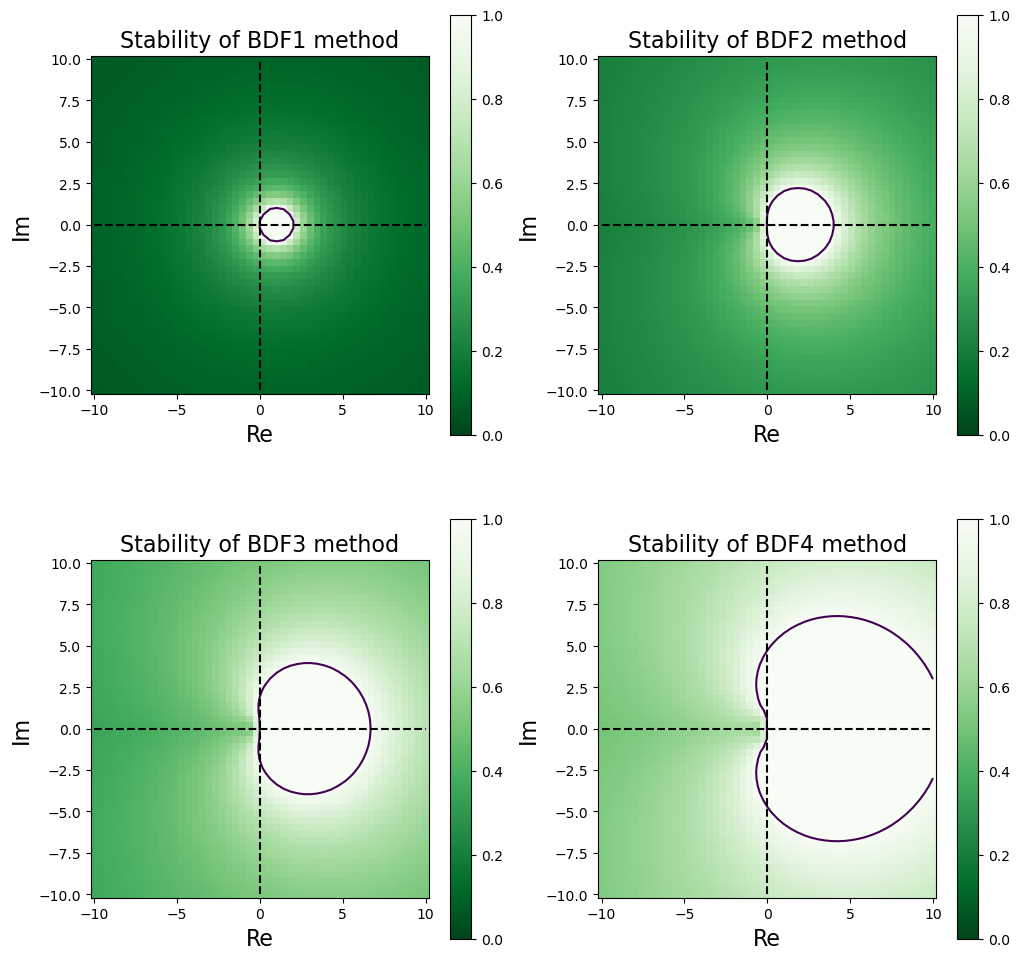

In [41]:
x = numpy.linspace(-10,10,50)
y = numpy.linspace(-10,10,50)
fig = plt.figure(figsize=(12,12))
axes = fig.add_subplot(2,2,1)
plot_stability_lmm(pi_BDF1, x, y, axes=axes, title='Stability of BDF1 method')

axes = fig.add_subplot(2,2,2)
plot_stability_lmm(pi_BDF2, x, y, axes=axes, title='Stability of BDF2 method')

axes = fig.add_subplot(2,2,3)
plot_stability_lmm(pi_BDF3, x, y, axes=axes, title='Stability of BDF3 method')

axes = fig.add_subplot(2,2,4)
plot_stability_lmm(pi_BDF4, x, y, axes=axes, title='Stability of BDF4 method')


### BDF Schemes

#### Pro's

* LMM's so only require 1 (non-linear) solve per time step
* relatively easy to derive and code methods of variable order
* L-Stable and A-Stable

#### Con's
* Still need to deal solving for system's of non-linear equations
* LMM's are harder to make adaptive (but can do so using interpolation techniques)

#### Example,  BDF-1 for a general non-linear ODE

Consider the general $n$-dimensional nonlinear system of ODE's (e.g van-der pol oscillator or SIR problem) which can be written as 

$$
    \frac{d\mathbf{u}}{dt} = \mathbf{f}(t,\mathbf{u}), \quad \mathbf{u}(0) = \mathbf{u}_0
$$

where
$$
    \mathbf{u}(t) = \begin{bmatrix} u_1(t) \\ u_2(t) \\ \vdots \\ u_n(t) \end{bmatrix},\quad
    \mathbf{f}(t,\mathbf{u}) = \begin{bmatrix} f_1(t,\mathbf{u}) \\ f_2(t,\mathbf{u}) \\ \vdots \\ f_n(t,\mathbf{u}) \end{bmatrix}
$$

and $\mathbf{f}$ is a vector of scalar, possibly non-linear  functions of the solution vector $\mathbf{u}$
    

for example, in the Van-der-pol oscillator $n=2$ and

$$
    \mathbf{f}(t,\mathbf{u}) = \begin{bmatrix} u_2 \\ \mu(1 - u_1^2)u_2 - u_1 \end{bmatrix}
$$
    

## BDF-1 discretization (Backwards-Euler)

So the BDF-1 (Backwards Euler) discretization of this system can be written

$$
    \mathbf{U}_{n+1} - \mathbf{U}_{n} - \Delta t\mathbf{f}(t,\mathbf{U}_{n+1}) = \mathbf{0}
$$

Which itself is a more general system of non-linear Equations for $\mathbf{U}_{n+1}$ of form

$$
    \mathbf{F}(\mathbf{U}_{n+1}) = \begin{bmatrix} F_1(t,\mathbf{U}_{n+1},\mathbf{U}_n) \\
    F_2(t,\mathbf{U}_{n+1},\mathbf{U}_n) \\
    \vdots\\
    F_n(t,\mathbf{U}_{n+1},\mathbf{U}_n)\\ \end{bmatrix} =
    \mathbf{0}
$$

where, in this case
$$
    F_i = {U_{i}}_{(n+1)} - {U_{i}}_{(n)} - \Delta tf_i(t,\mathbf{U}_{n+1})
$$

## Solution of systems of Non-linear equations:  Newton's method

If our system had only one scalar variable and function $f(t,u)$, then each step would reduce to solving the scalar non-linear problem
$$
    F(u_{n+1}) = 0
$$
which is a rootfinding problem, and we could use any of our rootfinders to solve this (in particular we could use robust bracketing schemes like brent).  Unfortunately once we move to higher-dimensions the problems become significantly harder (and solutions may not exist).  However we can still attempt to apply Newton's method to the general non-linear problem

$$
    \mathbf{F}(\mathbf{x}) = \mathbf{0}
$$

##  Newton's method: preliminaries

As a simpler non-linear system, we will consider the system of equations

$$
\begin{align}
    x_1^2 + 2x_2^2 &=\gamma_1 \\
    x_1 + 5x_2 &=\gamma_2 \\
\end{align}
$$

which geometrically is the intersection of an ellipse and a straight line, which, depending on the values of $\gamma_1$ and $\gamma_2$ should have 0,1, or 2 solutions



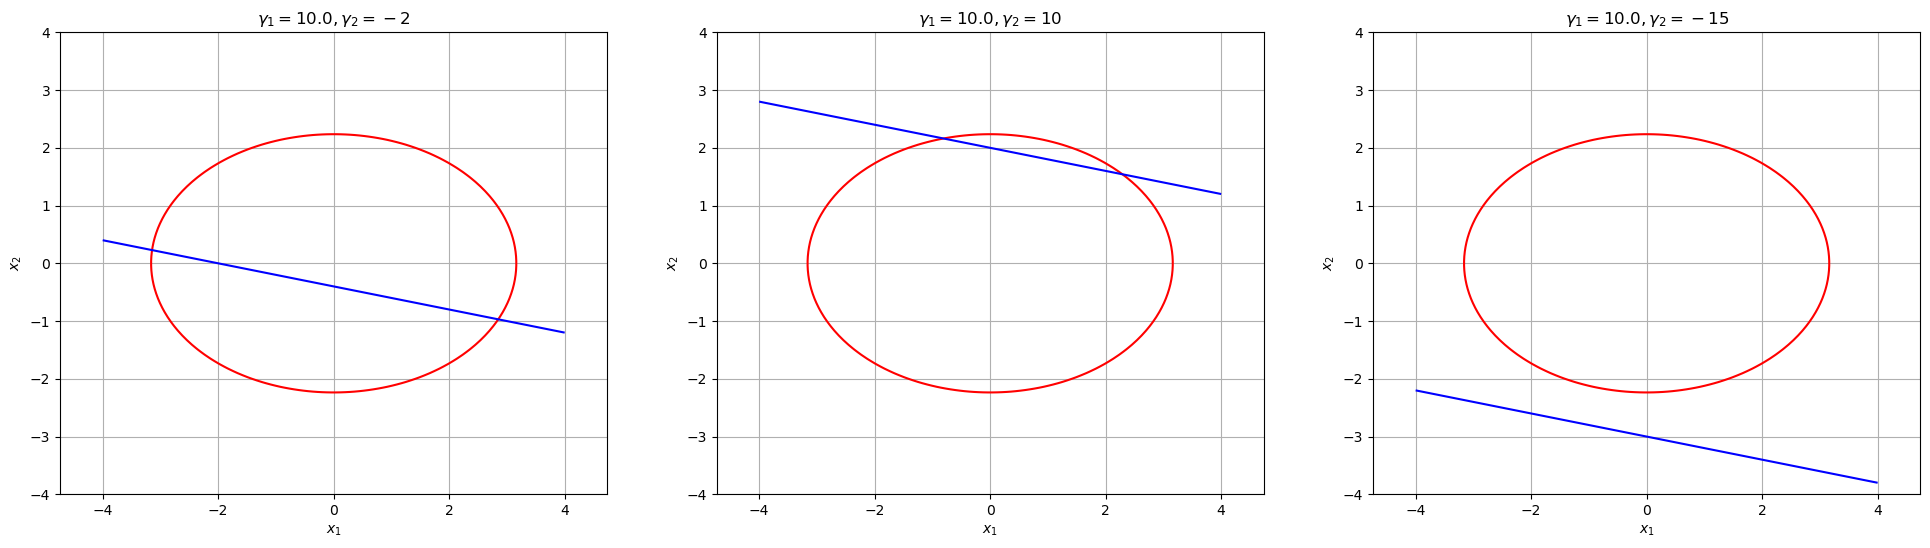

In [42]:
x = numpy.linspace(-4,4,100)
y = numpy.linspace(-4,4,100)
X,Y = numpy.meshgrid(x,y)

Z1 = lambda gamma: X**2 + 2*Y**2 - gamma
Z2 = lambda gamma: X + 5*Y - gamma

gamma_1 = 10*numpy.ones(3)
gamma_2 = [-2, 10, -15]
fig = plt.figure(figsize=(24,6))

for i in range(3):
    axes = fig.add_subplot(1,3,i+1)
    axes.contour(X,Y,Z1(gamma_1[i]),[0],colors='r')
    axes.contour(X,Y,Z2(gamma_2[i]),[0],colors='b')
    axes.axis('equal')

    axes.set_xlabel('$x_1$')
    axes.set_ylabel('$x_2$')
    axes.set_title('$\gamma_1={}, \gamma_2={}$'.format(gamma_1[i],gamma_2[i]))
    axes.grid()

plt.show()


Now this system is sufficiently simple that we could solve it using substitution and solve
a quadratic equation for the roots (or even use a 1-D rootfinder).  But in general we would like a more general method where we can start from some initial guess and rapidly converge to one of the roots.  Newton's method provides a general way to solve these sorts of problems (with all the issues that go with Newton for scalar problems)

##  Newton's method: Review $f(x)=0$

Newton's method for a scalar function of a single variable says, given any $x$ such that $f(x)\neq 0$, there should be a correction $\delta$ such that

$$
    f(x+\delta) = 0
$$

Or expanding in a Taylor's series around $x$

$$
    f(x+\delta) = f(x) + f'(x)\delta + O(f''\delta^2) = 0
$$

Neglecting the higher order terms this becomes  

$$
    f(x) + f'(x)\delta = 0
$$

or solving for the correction
$$
    \delta =\frac{-f(x)}{f'(x)}
$$

If the correction were exact it would follow that $f(x+\delta)=0$ and we would have our solution. 

In general,  the higher-order terms are important so the residual is not zero, but this gives us an iterative scheme that we hope will converge

Set an initial guess $x_0$. Then iterate for $k=0,1,2\ldots$ 

$$  
\begin{align}
    \text{Solve:} & & \delta_k &= \frac{-f(x_k)}{f'(x_k)}\\
    & & x_{k+1} &= x_k + \delta_k
\end{align}
$$

until $|f(x_k)| < \text{tol}$

If $f$ is well behaved with simple roots and the initial guess is within the basin of attraction of a given root,  Newton can find the root with quadratic convergence.


It can also behave very badly and fly off to infinity...

##  Newton's method: $\mathbf{F}(\mathbf{x})=\mathbf{0}$

Newton's method for a vector valued function is actually very similar (without the comfort of things such as brackets)

Again for general $\mathbf{x}$, $\mathbf{F}(\mathbf{x})\neq\mathbf{0}$ but is a vector often called the "residual".

By the rules of vector norms 

$$
    ||\mathbf{F}(\mathbf{x})|| \geq 0
$$

and is only zero at a root of $\mathbf{F}$.



If the residual is non-zero for some arbitrary $\mathbf{x}$, Newton's method assumes that there is some correction *vector* $\boldsymbol{\delta}$ such that

$$
\mathbf{F}(\mathbf{x}+\boldsymbol{\delta})=\mathbf{0}
$$
    
And we simply need to expand a vector-valued function in its Taylor series and truncate at linear terms to solve for the correction.  

#### Preliminaries:  Taylor Series expansion of   $f(\mathbf{x}):\mathbb{R}^n\rightarrow\mathbb{R}$.  

if $f(\mathbf{x})$ is a scalar function of a vector valued variable (e.g. a surface like $f_1(\mathbf{x}$), then the Taylor series of

$$
    f(\mathbf{x} +\boldsymbol{\delta}) = f(\mathbf{x}) + \sum_{i=1}^n \frac{\partial f}{\partial x_i}(\mathbf{x})\delta_i + \frac{1}{2}\sum_{j=1}^n\sum_{i=1}^n \frac{\partial^2 f}{\partial x_i\partial x_j}(\mathbf{x})\delta_i\delta_j + HOT
$$

or more beautifully in vector notation
$$
    f(\mathbf{x} +\boldsymbol{\delta}) = f(\mathbf{x}) + (\nabla f)^T\boldsymbol{\delta} + \frac{1}{2}\boldsymbol{\delta}^TH(\mathbf{x})\boldsymbol{\delta} +  HOT
$$

where $\nabla f$ is the gradient of $f$,  and $H$ is the Hessian, a symmetric matrix whose components are
$$
    H_{ij} = \frac{\partial^2 f}{\partial x_i\partial x_j}
$$ 


####  Taylor Series expansion of   $\mathbf{F}(\mathbf{x}):\mathbb{R}^n\rightarrow\mathbb{R}^n$.  

This is readily extended to vector valued functions as
$$
    \mathbf{F}(\mathbf{x}+\boldsymbol{\delta}) = \begin{bmatrix}
        F_1(\mathbf{x}+\boldsymbol{\delta}) \\
        F_2(\mathbf{x}+\boldsymbol{\delta}) \\
        \vdots \\
        F_n(\mathbf{x}+\boldsymbol{\delta}) \\
        \end{bmatrix} \approx \begin{bmatrix}
        F_1(\mathbf{x}) + (\nabla F_1)^T\boldsymbol{\delta} \\
        F_2(\mathbf{x}) + (\nabla F_2)^T\boldsymbol{\delta} \\
        \vdots \\
        F_n(\mathbf{x}) + (\nabla F_n)^T\boldsymbol{\delta} \\
\end{bmatrix} + HOT
$$
                        

or more succinctly as 

$$
\mathbf{F}(\mathbf{x}+\boldsymbol{\delta}) \approx \mathbf{F}(\mathbf{x}) + J(\mathbf{x})\boldsymbol{\delta}
$$

where $J$ is the ``Jacobian'' of $\mathbf{F}$

####  The Jacobian

The Jacobian of $\mathbf{F}(\mathbf{x})$ is the matrix whose rows are the gradients of the individual functions $F_i(\mathbf{x})$

$$
 J = 
    \begin{bmatrix}
        \nabla F_1^T \\
        \nabla F_2^T \\
        \vdots \\
        \nabla F_n^T\\
\end{bmatrix}
$$
     

or whose components are 

$$
    J_{ij} = \frac{\partial F_i}{\partial x_j}
$$

i.e. all the partial derivatives of all the functions with respect to all the variables

### Example

Our toy non-linear problem 
$$
\begin{align}
    x_1^2 + 2x_2^2 &=\gamma_1 \\
    x_1 + 5x_2 &=\gamma_2 \\
\end{align}
$$

Can be rewritten in residual form as 
$$
\mathbf{F}(\mathbf{x}) = \begin{bmatrix}
    x_1^2 + 2x_2^2 - \gamma_1 \\
    x_1 + 5x_2 - \gamma_2 \\
 \end{bmatrix}
$$

with Jacobian?

$$
    J(\mathbf{x}) = \begin{bmatrix}
    2x_1 &  4x_2  \\
    1 & 5  \\
 \end{bmatrix}
$$

## Newton's method for $\mathbf{F}(\mathbf{x}) = \mathbf{0}$ (finally)

Given all the pieces,  raw Newton for $\mathbf{F}(\mathbf{x}):\mathbb{R}^n\rightarrow\mathbb{R}^n$ is simply

given an initial guess $\mathbf{x}$ such that $\mathbf{F}(\mathbf{x})\neq\mathbf{0}$: seek a correction such that


$$
   \mathbf{F}(\mathbf{x}+\boldsymbol{\delta})\approx \mathbf{F}(\mathbf{x}) + J\boldsymbol{\delta} = \mathbf{0} 
$$ 

or solve

$$
    J\boldsymbol{\delta} = -\mathbf{F}(\mathbf{x})
$$ 

and correct $\mathbf{x}\leftarrow\mathbf{x}+\boldsymbol{\delta}$

    

or as an iterative scheme:

Set an initial guess $x_0$. Then iterate for $k=0,1,2\ldots$ 

$$  
\begin{align}
    \text{Solve:} & &  J(\mathbf{x}_k)\boldsymbol{\delta_k} &= -\mathbf{F}(\mathbf{x}_k)\\
    & &\mathbf{x}_{k+1} &= \mathbf{x}_k + \boldsymbol{\delta}_k
\end{align}
$$

until $||\mathbf{F}(\mathbf{x}_k)|| < \text{tol}$
    

### Minor digression: Linear systems

We can actually use Newton to solve linear systems as well.  Consider the general linear problem

$$
    A\mathbf{x} = \mathbf{b}
$$

which we can rewrite in residual form as 

$$
    \mathbf{F}(\mathbf{x}) =  A\mathbf{x} - \mathbf{b} = \mathbf{0}
$$

i.e. the solution of our original problem is also a root of $\mathbf{F}$.




For any other initial guess $\mathbf{x}_0$,  $\mathbf{F}(\mathbf{x}_0)\neq\mathbf{0}$.  However we can easily find the correction $\boldsymbol{\delta}$ as

$$
\begin{align}
 \mathbf{F}(\mathbf{x}_0+\boldsymbol{\delta})&= A\mathbf{x_0} + A\boldsymbol{\delta} -\mathbf{b} = \mathbf{0}\\
      &=A\boldsymbol{\delta} + \mathbf{F}(\mathbf{x}_0) = \mathbf{0}\\
\end{align}
$$

which we can solve immediately for the correction by solving the linear problem
$$
    A\boldsymbol{\delta} = -\mathbf{F}(\mathbf{x}_0)
$$

Which is the same as the general Newton problem if $A=J$

But it is!

if 
$$
    \mathbf{F}(\mathbf{x}) = A\mathbf{x} - \mathbf{b}
$$

Then in index notation
$$
    F_i(\mathbf{x}) = \sum_{j} a_{ij}x_j - b_i
$$

And the Jacobian
$$
    J_{ij} = \frac{\partial F_i}{\partial x_j} = a_{ij}
$$
or $J = A$

Or the solution of our original problem is 

$$
\begin{align}
    \mathbf{x} &= \mathbf{x}_0 + \boldsymbol{\delta} \\
    &= \mathbf{x}_0 - A^{-1}\mathbf{F}(\mathbf{x_0})
\end{align}
$$

Which for a simple linear function $\mathbf{F}(\mathbf{x}) = A\mathbf{x} - \mathbf{b}$ becomes

$$ 
\begin{align*}
    \mathbf{x} &= \mathbf{x}_0 - A^{-1}\left(A\mathbf{x}_0 - \mathbf{b}\right) \\
                &= A^{-1}\mathbf{b}\\
\end{align*}
$$

Thus we can solve for either the solution itself or the correction with the residual.  These are equivalent

In [43]:
# Some quick and dirty Code
def newton(F,J,x0,tol=1.e-6,MAX_ITS=100,verbose=True):
    """ Solve F(x) = 0 using Newton's method until ||F(x)|| < tol or reaches Max iterations
    
    Params:
    -------
        F: calleable: 
            Function returning residual F(x)
        J: calleable
            Function returning Jacobian J(x)
        tol: float
            stopping criteria for ||F|| < tol
        MAX_ITS: integer
            maximum number of iterations
        verbose: bool
            if true spits out norm of the residual at each iteration
            
    Returns:
    --------
        x: list
            list of points for each Newton iteration (just used for plotting intermediate results)
            the solution is x[-1]
    Raises:
    -----------
        ValueError if number of its exceeds MAX_ITS
        
    """
    x = [ x0 ]
    for k in range(MAX_ITS+1):
        xk = x[k]
        res = numpy.linalg.norm(F(xk))
        if verbose:
            print('k = {}, ||F|| = {}'.format(k,res))
        delta = numpy.linalg.solve(J(xk),-F(xk))
        x.append( xk + delta)
        
        if res < tol: 
            return numpy.array(x), k
                
    raise ValueError('Maximum number of iterations exceeded {}'.format(MAX_ITS))
    
    
    

### Let's test with our toy problem


In [44]:
gamma = numpy.array([10, -2])

F = lambda x: numpy.array([ x[0]**2 + 2*x[1]**2 - gamma[0],
                            x[0]    + 5*x[1]    - gamma[1] ])

J = lambda x: numpy.array([[ 2*x[0],  4*x[1] ],
                           [ 1    ,    5   ]])

In [45]:
x0 = numpy.array([-.5, 2])

x, nits = newton(F,J,x0)
print('\n',x)

k = 0, ||F|| = 11.632390124131842
k = 1, ||F|| = 61.1875
k = 2, ||F|| = 13.2030137755102
k = 3, ||F|| = 1.9024940272923612
k = 4, ||F|| = 0.07796445502166449
k = 5, ||F|| = 0.0001553532625546694
k = 6, ||F|| = 6.217799608521091e-10

 [[-0.5         2.        ]
 [-8.25        1.25      ]
 [-4.75357143  0.55071429]
 [-3.42633048  0.2852661 ]
 [-3.15764979  0.23152996]
 [-3.14565623  0.22913125]
 [-3.14563223  0.22912645]
 [-3.14563223  0.22912645]]


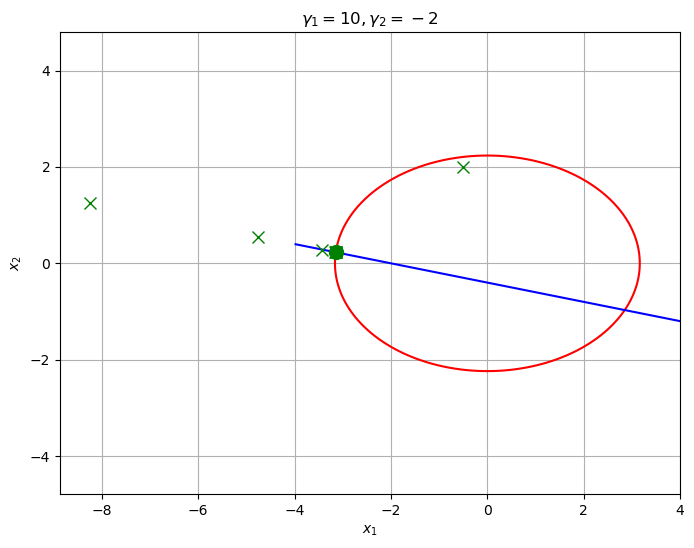

In [46]:
xa = numpy.linspace(-4,4,100)
ya = numpy.linspace(-4,4,100)
X,Y = numpy.meshgrid(xa,ya)

Z1 = lambda gamma: X**2 + 2*Y**2 - gamma
Z2 = lambda gamma: X + 5*Y - gamma

fig = plt.figure(figsize=(8,6))

axes = fig.add_subplot(1,1,1)
axes.contour(X,Y,Z1(gamma[0]),[0],colors='r')
axes.contour(X,Y,Z2(gamma[1]),[0],colors='b')
for xi in x:    
    axes.plot(xi[0],xi[1],'gx',markersize=8)
axes.plot(xi[0],xi[1],'go',markersize=10)

axes.axis('equal')

axes.set_xlabel('$x_1$')
axes.set_ylabel('$x_2$')
axes.set_title('$\gamma_1={}, \gamma_2={}$'.format(gamma[0],gamma[1]))
axes.grid()

plt.show()


### A project idea:  

Write an adaptive BDF-2/BDF-3  scheme that can solve a general non-linear problem and test it using the vander-pol oscillator.  This turns out to be a lot more challenging than it looks for the vander-pol problem.